# Generador de rostros artificiales mediante redes adversativas

Durante el entrenamiento se agregara ruido a las imagenes reales (se mantiene el dropout)

En una red adversaria se tienen dos modelos (que pueden ser Redes Neuronales o Convolucionales) compitiendo: un Generador y un Discriminador.

Se genera un primer modelo que llamaremos Discriminador para que sea capaz de reconocer rostros humanos. Este discriminador será simplemente un clasificador,que buscara indicar si una imagen es real o falsa

Se genera un segundo modelo, que llamaremos Generador y nuestro objetivo es entrenarlo para que sea capaz de tomar una entrada aleatoria y a la salida generar algo muy parecido a una imagen de un rostro.

La idea es entrenar esos dos modelos simultáneamente buscando que al final sea el Generador el vencedor en esta competencia.

## Funciones y carga de datos

In [1]:
TAM_ENTRADA = 100 # vector de entrada del modelo
TAM_IMG = 32 # tamaño de la imagen

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

### Funcion para carga y visualizar datos

In [3]:
def cargar_datos(dataset):
    print('Creando set de entrenamiento...')
    filelist = os.listdir(dataset)

    n_imgs = len(filelist)
    x_train = np.zeros((n_imgs,TAM_IMG,TAM_IMG,3))

    for i in range(n_imgs):
        direcion = str(dataset)+ "\\" + str(filelist[i])
        imagen = cv2.imread(direcion,1)
        imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
        imagen = cv2.resize(imagen, dsize=(TAM_IMG, TAM_IMG))
        imagen = (imagen - 127.5)/127.5 #para dejarlo entre -1 y 1
        x_train[i,:] = imagen
    print('¡Listo!')

    return x_train

def visualizar_imagen(imagen):
    imagen = imagen * 0.5 + 0.5 #para pasarlo de 0 a 1
    plt.imshow(imagen)
    plt.show()


In [4]:
def visualizarMosaico(GAN, w= 3, h=3):
    
    fig, axs = plt.subplots(w,h,figsize=(h*2,w*2))
    
    for i in range(w):
        for j in range(h):
            ruido = np.random.normal(0, 1, TAM_ENTRADA)
            ruido = np.array([ruido])
            imagen = GAN.layers[0].predict(ruido)
            imagen = imagen * 0.5 + 0.5
            imagen = imagen.reshape(TAM_IMG, TAM_IMG, 3)
            axs[i][j].imshow(imagen)
            

### Funciones para crear el modelo

In [5]:
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, Conv2D, LeakyReLU, Flatten, Input, UpSampling2D, Dropout
import tensorflow.keras.optimizers as optimizador
import time
import seaborn as sns

In [6]:
def crear_generador():
    modelo = Sequential(name = "Generador")
    
    modelo.add(Dense(int(TAM_IMG/8)*int(TAM_IMG/8)*256, use_bias=False, input_shape=(TAM_ENTRADA,)))
    
    modelo.add(Reshape((int(TAM_IMG/8), int(TAM_IMG/8),256))) #512
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    #Tamaño resultante: 4x4x512

    modelo.add(Conv2DTranspose(128, 3, strides = 2, padding='same', use_bias=False))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    #Tamaño resultante: 8x8x256

    modelo.add(Conv2DTranspose(64, 5, strides = 2, padding='same', use_bias=False))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    #Tamaño resultante: 16x16x128
 
    modelo.add(Conv2DTranspose(3, 5, strides = 2, activation = 'tanh', padding='same', use_bias=False))
    #Tamaño resultante: 32x32x3
    
    print("Generador Creado")
    return modelo


In [7]:
def crear_discriminador(optimizador, error):
    
    modelo = Sequential(name = "Discriminador")

    modelo.add(Conv2D(32, 5, strides=1, padding='same', use_bias=False, input_shape=(TAM_IMG,TAM_IMG,3)))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    modelo.add(Dropout(0.2))
    #32x32x32
    
    modelo.add(Conv2D(64, 5, strides=2, padding='same', use_bias=False, input_shape=(TAM_IMG,TAM_IMG,3)))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    modelo.add(Dropout(0.2))
    #16x16x64

    modelo.add(Conv2D(128, 5, strides=2, padding='same', use_bias=False))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    modelo.add(Dropout(0.2))
    #8x8x128
    
    modelo.add(Conv2D(256, 5, strides=2, padding='same', use_bias=False))
    modelo.add(BatchNormalization())
    modelo.add(LeakyReLU())
    modelo.add(Dropout(0.2))
    #4x4x256
    
    modelo.add(Flatten())
    modelo.add(Dense(1, activation='sigmoid', use_bias=False))

    modelo.compile(optimizer = optimizador, loss= error)

    print("Discriminador Creado")
    return modelo

In [8]:
def crear_GAN(optimizador_g, error_g, optimizador_d=None, error_d=None):
    
    if optimizador_d==None:
        optimizador_d = optimizador_g
    
    if error_d==None:
        error_d = error_g
        
    generador = crear_generador()
    discriminador = crear_discriminador(optimizador_d, error_d)
    
    modelo = Sequential(name = "GAN")
    modelo.add(generador)
    discriminador.trainable = False
    modelo.add(discriminador)
    
    modelo.compile(optimizer = optimizador_g, loss= error_g)

    print("GAN Creado")
    return modelo


In [9]:
def predicion(GAN, ruido):
    print(GAN(ruido))  
    imagen = GAN.layers[0].predict(ruido)
    visualizar_imagen(imagen.reshape(TAM_IMG, TAM_IMG, 3))

### Funciones para el entrenamiento

En el caso de las Redes Adversarias debemos llevar a cabo estos pasos:

1. “Descongelar” los coeficientes del Discriminador
2. Entrenar solo el Discriminador con imagenes falsas y reales
3. “Congelar” los coeficientes del Discriminador
4. Entrenar la GAN, al estar congelado el discriminador únicamente se entrenara el Generador
5. Repetir los pasos 1 a 4 por el número de iteraciones que se vayan a usar el entrenamiento

In [10]:
 def entrenar(GAN, ITERACIONES, TAM_LOTE, CARPETAGUARDADO, GUARDAR_IMG = 100):
    
    generador = GAN.layers[0]
    discriminador = GAN.layers[1]
    error_d_acumulado = np.array([])
    error_g_acumulado = np.array([])
    prediccion_falsa = np.array([])
    
    for i in range(1, ITERACIONES+1):
        start = time.time()
        print("Comenzando Epoca " + str(i), end = "")

        # Crear un "batch" de imágenes falsas y otro con imágenes reales
        ruido = np.random.normal(0, 1, [TAM_LOTE, TAM_ENTRADA])
        batch_falsas = generador.predict(ruido)

        idx = np.random.randint(low=0, high=x_train.shape[0], size= TAM_LOTE)
        batch_reales = x_train[idx]
        
         # Agregamos ruidos a las imagenes segun el LEVEL_NOISE
        batch_reales = batch_reales + LEVEL_NOISE * np.random.normal(loc=0.0, scale=1.0, size=batch_reales.shape)

        # lo ajustamos para que no pase del rango (-1, 1)
        batch_reales = np.clip(batch_reales, -1, 1)

        #la unificacion del batch de entrenamiento es lo que logra que el modelo aprenda
        batch = np.concatenate((batch_reales, batch_falsas))

        #las reales le digo como resultado 1 con np.ones (el 0.9 ayuda a que converga mejor)
        #las falsas le digo como resultado 0 con np.zeros
        valores = np.concatenate((np.ones(TAM_LOTE)*0.9, np.zeros(TAM_LOTE)))

        print(".", end = "")

        discriminador.trainable = True

        # Entrenar discriminador con imagener falsas y reales
        dError = discriminador.train_on_batch(batch, valores)

        error_d_acumulado = np.append(error_d_acumulado, dError)

        #congelo el discriminador
        discriminador.trainable = False

        print(".", end = "")

        # Entrenar GAN: se generará ruido aleatorio y se presentará a la GAN como si fuesen imagenes reales
        ruido = np.random.normal(0, 1, [TAM_LOTE, TAM_ENTRADA])
        gError = GAN.train_on_batch(ruido, np.ones(TAM_LOTE))
            
        error_g_acumulado = np.append(error_g_acumulado, gError)

        print(".", end = "")

        #Cada 100 iteraciones vamos a guardar una imagen
        if i==1 or i%GUARDAR_IMG == 0:
            ruido = np.random.normal(0, 1, TAM_ENTRADA)
            ruido = np.array([ruido])
            resultado = generador.predict(ruido)
            resultado = resultado * 0.5 + 0.5
            plt.imshow(resultado.reshape(TAM_IMG, TAM_IMG, 3))
            plt.savefig(CARPETAGUARDADO + "/r" + str(i) + ".png")

        #hacemos una prueba de prediccion
        ruido = np.random.normal(0, 1, TAM_ENTRADA)
        ruido = np.array([ruido])
        resultado = GAN.predict(ruido)

        prediccion_falsa = np.append(prediccion_falsa, resultado)
        end = time.time()
        print(" Fin")
        print("Tiempo transcurrido: ", round((end - start), 2), "s")
        trm = (ITERACIONES + 1 - i) * (end - start) / 60 #tiempo restante en minutos
        print("Tiempo restante aprox: " + str(round(trm, 2)) + "m -> " + str(int(trm/60)) + ":" + str(int(trm%60)) + "h")
        print("prediccion de ruido: ", resultado)
        print("===================================================================")
     
    return error_d_acumulado, error_g_acumulado, prediccion_falsa
            
def plot_acumulado(tamaño, lim_sup = 1, **valores):
    t = np.linspace(1, tamaño, tamaño)
    plt.figure(figsize=(20, 6))
    plt.ylim(0, lim_sup)
    for v in valores:
        sns.lineplot(x=t, y=valores[v], label=v)


## Carga de datos

In [16]:
x_train = cargar_datos("dataset1")

Creando set de entrenamiento...
¡Listo!


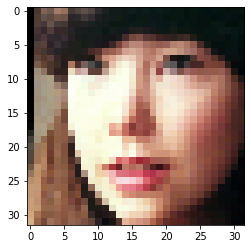

In [16]:
visualizar_imagen(x_train[12])

## Prueba de modelos

### Primer prueba

In [17]:
OPTIMIZADOR1 = optimizador.Adam(learning_rate=0.0002, beta_1=0.5) 
ERROR1 = 'binary_crossentropy' 

gan1 = crear_GAN(OPTIMIZADOR1, ERROR1)

Generador Creado
Discriminador Creado
GAN Creado


Comenzando Epoca 1... Fin
Tiempo transcurrido:  5.13 s
Tiempo restante aprox: 256.42m -> 4:16h
prediccion de ruido:  [[0.50027174]]
Comenzando Epoca 2... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 126.95m -> 2:6h
prediccion de ruido:  [[0.4968279]]
Comenzando Epoca 3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 126.51m -> 2:6h
prediccion de ruido:  [[0.49094144]]
Comenzando Epoca 4... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 126.43m -> 2:6h
prediccion de ruido:  [[0.48548025]]
Comenzando Epoca 5... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 128.19m -> 2:8h
prediccion de ruido:  [[0.4817239]]
Comenzando Epoca 6... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 125.65m -> 2:5h
prediccion de ruido:  [[0.47607878]]
Comenzando Epoca 7... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 130.25m -> 2:10h
prediccion de ruido:  [[0.4705575]]
Comenzando Epoca 8... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 131.51

Comenzando Epoca 83... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 123.6m -> 2:3h
prediccion de ruido:  [[0.06513232]]
Comenzando Epoca 84... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 122.86m -> 2:2h
prediccion de ruido:  [[0.03197885]]
Comenzando Epoca 85... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 122.71m -> 2:2h
prediccion de ruido:  [[0.0321027]]
Comenzando Epoca 86... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 123.49m -> 2:3h
prediccion de ruido:  [[0.05058566]]
Comenzando Epoca 87... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 122.7m -> 2:2h
prediccion de ruido:  [[0.04669562]]
Comenzando Epoca 88... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 123.33m -> 2:3h
prediccion de ruido:  [[0.04652423]]
Comenzando Epoca 89... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 122.53m -> 2:2h
prediccion de ruido:  [[0.03811222]]
Comenzando Epoca 90... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 

Comenzando Epoca 124... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 128.32m -> 2:8h
prediccion de ruido:  [[0.0190241]]
Comenzando Epoca 125... Fin
Tiempo transcurrido:  2.86 s
Tiempo restante aprox: 136.88m -> 2:16h
prediccion de ruido:  [[0.0280138]]
Comenzando Epoca 126... Fin
Tiempo transcurrido:  2.86 s
Tiempo restante aprox: 137.2m -> 2:17h
prediccion de ruido:  [[0.04382122]]
Comenzando Epoca 127... Fin
Tiempo transcurrido:  2.77 s
Tiempo restante aprox: 132.44m -> 2:12h
prediccion de ruido:  [[0.04874289]]
Comenzando Epoca 128... Fin
Tiempo transcurrido:  2.99 s
Tiempo restante aprox: 142.99m -> 2:22h
prediccion de ruido:  [[0.31526333]]
Comenzando Epoca 129... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 127.36m -> 2:7h
prediccion de ruido:  [[0.6682469]]
Comenzando Epoca 130... Fin
Tiempo transcurrido:  2.99 s
Tiempo restante aprox: 142.87m -> 2:22h
prediccion de ruido:  [[0.06707925]]
Comenzando Epoca 131... Fin
Tiempo transcurrido:  2.85 s
Tiempo rest

Comenzando Epoca 165... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 119.45m -> 1:59h
prediccion de ruido:  [[0.00092116]]
Comenzando Epoca 166... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 118.67m -> 1:58h
prediccion de ruido:  [[0.00022808]]
Comenzando Epoca 167... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 119.37m -> 1:59h
prediccion de ruido:  [[0.00031295]]
Comenzando Epoca 168... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 118.59m -> 1:58h
prediccion de ruido:  [[0.01820999]]
Comenzando Epoca 169... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 118.55m -> 1:58h
prediccion de ruido:  [[0.01180887]]
Comenzando Epoca 170... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 119.38m -> 1:59h
prediccion de ruido:  [[0.00018999]]
Comenzando Epoca 171... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 119.94m -> 1:59h
prediccion de ruido:  [[0.0119842]]
Comenzando Epoca 172... Fin
Tiempo transcurrido:  2.53 s
Tiempo

Comenzando Epoca 206... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 117.05m -> 1:57h
prediccion de ruido:  [[0.04772255]]
Comenzando Epoca 207... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 117.19m -> 1:57h
prediccion de ruido:  [[0.06032559]]
Comenzando Epoca 208... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 116.91m -> 1:56h
prediccion de ruido:  [[0.14997995]]
Comenzando Epoca 209... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 116.87m -> 1:56h
prediccion de ruido:  [[0.11375302]]
Comenzando Epoca 210... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 117.56m -> 1:57h
prediccion de ruido:  [[0.01422346]]
Comenzando Epoca 211... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 116.79m -> 1:56h
prediccion de ruido:  [[0.03387859]]
Comenzando Epoca 212... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 117.47m -> 1:57h
prediccion de ruido:  [[0.10643855]]
Comenzando Epoca 213... Fin
Tiempo transcurrido:  2.51 s
Tiemp

Comenzando Epoca 247... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 118.47m -> 1:58h
prediccion de ruido:  [[0.20604098]]
Comenzando Epoca 248... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 119.74m -> 1:59h
prediccion de ruido:  [[0.09709439]]
Comenzando Epoca 249... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 120.42m -> 2:0h
prediccion de ruido:  [[0.00056288]]
Comenzando Epoca 250... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 115.25m -> 1:55h
prediccion de ruido:  [[0.08309481]]
Comenzando Epoca 251... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 116.87m -> 1:56h
prediccion de ruido:  [[0.00701106]]
Comenzando Epoca 252... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 117.03m -> 1:57h
prediccion de ruido:  [[0.3212052]]
Comenzando Epoca 253... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 115.75m -> 1:55h
prediccion de ruido:  [[0.27134898]]
Comenzando Epoca 254... Fin
Tiempo transcurrido:  2.57 s
Tiempo 

Comenzando Epoca 288... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 113.57m -> 1:53h
prediccion de ruido:  [[9.397695e-07]]
Comenzando Epoca 289... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 113.53m -> 1:53h
prediccion de ruido:  [[1.0865522e-06]]
Comenzando Epoca 290... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 114.19m -> 1:54h
prediccion de ruido:  [[4.481325e-06]]
Comenzando Epoca 291... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 112.74m -> 1:52h
prediccion de ruido:  [[9.57238e-07]]
Comenzando Epoca 292... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 113.4m -> 1:53h
prediccion de ruido:  [[1.2112439e-07]]
Comenzando Epoca 293... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 113.6m -> 1:53h
prediccion de ruido:  [[7.936137e-05]]
Comenzando Epoca 294... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 113.32m -> 1:53h
prediccion de ruido:  [[4.0983824e-07]]
Comenzando Epoca 295... Fin
Tiempo transcurrido: 

Comenzando Epoca 329... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 112.55m -> 1:52h
prediccion de ruido:  [[0.00013816]]
Comenzando Epoca 330... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 113.89m -> 1:53h
prediccion de ruido:  [[0.00018233]]
Comenzando Epoca 331... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 113.85m -> 1:53h
prediccion de ruido:  [[6.190303e-05]]
Comenzando Epoca 332... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 113.16m -> 1:53h
prediccion de ruido:  [[0.00030366]]
Comenzando Epoca 333... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 117.89m -> 1:57h
prediccion de ruido:  [[0.0001272]]
Comenzando Epoca 334... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 116.99m -> 1:56h
prediccion de ruido:  [[8.651604e-05]]
Comenzando Epoca 335... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 119.74m -> 1:59h
prediccion de ruido:  [[0.018749]]
Comenzando Epoca 336... Fin
Tiempo transcurrido:  2.66 s
Tiem

Comenzando Epoca 370... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 115.61m -> 1:55h
prediccion de ruido:  [[0.19080812]]
Comenzando Epoca 371... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 114.97m -> 1:54h
prediccion de ruido:  [[0.14816183]]
Comenzando Epoca 372... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 118.0m -> 1:58h
prediccion de ruido:  [[0.26756984]]
Comenzando Epoca 373... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 119.18m -> 1:59h
prediccion de ruido:  [[0.04667482]]
Comenzando Epoca 374... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 118.86m -> 1:58h
prediccion de ruido:  [[0.40044293]]
Comenzando Epoca 375... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 116.51m -> 1:56h
prediccion de ruido:  [[0.04869649]]
Comenzando Epoca 376... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 115.43m -> 1:55h
prediccion de ruido:  [[0.00177503]]
Comenzando Epoca 377... Fin
Tiempo transcurrido:  2.69 s
Tiempo

Comenzando Epoca 411... Fin
Tiempo transcurrido:  2.78 s
Tiempo restante aprox: 120.12m -> 2:0h
prediccion de ruido:  [[6.4227254e-07]]
Comenzando Epoca 412... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 115.83m -> 1:55h
prediccion de ruido:  [[3.7119953e-05]]
Comenzando Epoca 413... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 113.04m -> 1:53h
prediccion de ruido:  [[7.137625e-05]]
Comenzando Epoca 414... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 114.98m -> 1:54h
prediccion de ruido:  [[4.2107426e-06]]
Comenzando Epoca 415... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 114.97m -> 1:54h
prediccion de ruido:  [[7.952407e-06]]
Comenzando Epoca 416... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 114.46m -> 1:54h
prediccion de ruido:  [[2.1695043e-06]]
Comenzando Epoca 417... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 111.57m -> 1:51h
prediccion de ruido:  [[5.3755724e-05]]
Comenzando Epoca 418... Fin
Tiempo transcurr

Comenzando Epoca 452... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 109.28m -> 1:49h
prediccion de ruido:  [[2.8389397e-05]]
Comenzando Epoca 453... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 110.04m -> 1:50h
prediccion de ruido:  [[0.00068983]]
Comenzando Epoca 454... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 107.17m -> 1:47h
prediccion de ruido:  [[1.3666603e-08]]
Comenzando Epoca 455... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 106.83m -> 1:46h
prediccion de ruido:  [[0.00118071]]
Comenzando Epoca 456... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 107.47m -> 1:47h
prediccion de ruido:  [[2.7418058e-05]]
Comenzando Epoca 457... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 105.96m -> 1:45h
prediccion de ruido:  [[0.00471997]]
Comenzando Epoca 458... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 107.38m -> 1:47h
prediccion de ruido:  [[0.00011557]]
Comenzando Epoca 459... Fin
Tiempo transcurrido:  2.52

Comenzando Epoca 493... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 105.64m -> 1:45h
prediccion de ruido:  [[4.518101e-06]]
Comenzando Epoca 494... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 104.94m -> 1:44h
prediccion de ruido:  [[0.00113356]]
Comenzando Epoca 495... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 104.9m -> 1:44h
prediccion de ruido:  [[2.0578012e-05]]
Comenzando Epoca 496... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 104.29m -> 1:44h
prediccion de ruido:  [[3.386655e-06]]
Comenzando Epoca 497... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 104.86m -> 1:44h
prediccion de ruido:  [[0.00064254]]
Comenzando Epoca 498... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 104.78m -> 1:44h
prediccion de ruido:  [[2.7177655e-06]]
Comenzando Epoca 499... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 104.73m -> 1:44h
prediccion de ruido:  [[0.00017419]]
Comenzando Epoca 500... Fin
Tiempo transcurrido:  2.64

Comenzando Epoca 534... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 105.87m -> 1:45h
prediccion de ruido:  [[0.02771696]]
Comenzando Epoca 535... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 106.13m -> 1:46h
prediccion de ruido:  [[0.0025183]]
Comenzando Epoca 536... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 105.66m -> 1:45h
prediccion de ruido:  [[0.00494078]]
Comenzando Epoca 537... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 106.12m -> 1:46h
prediccion de ruido:  [[0.00038046]]
Comenzando Epoca 538... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 104.7m -> 1:44h
prediccion de ruido:  [[0.0297235]]
Comenzando Epoca 539... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 104.91m -> 1:44h
prediccion de ruido:  [[0.0053516]]
Comenzando Epoca 540... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 103.7m -> 1:43h
prediccion de ruido:  [[0.01505852]]
Comenzando Epoca 541... Fin
Tiempo transcurrido:  2.54 s
Tiempo res

Comenzando Epoca 575... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 108.46m -> 1:48h
prediccion de ruido:  [[6.2977e-05]]
Comenzando Epoca 576... Fin
Tiempo transcurrido:  2.77 s
Tiempo restante aprox: 111.8m -> 1:51h
prediccion de ruido:  [[9.6208125e-05]]
Comenzando Epoca 577... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 104.29m -> 1:44h
prediccion de ruido:  [[0.00040996]]
Comenzando Epoca 578... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 103.03m -> 1:43h
prediccion de ruido:  [[6.328915e-06]]
Comenzando Epoca 579... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 101.55m -> 1:41h
prediccion de ruido:  [[0.00049004]]
Comenzando Epoca 580... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 101.38m -> 1:41h
prediccion de ruido:  [[0.0311006]]
Comenzando Epoca 581... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 101.93m -> 1:41h
prediccion de ruido:  [[0.00100252]]
Comenzando Epoca 582... Fin
Tiempo transcurrido:  2.51 s
Ti

Comenzando Epoca 616... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 101.41m -> 1:41h
prediccion de ruido:  [[0.05125338]]
Comenzando Epoca 617... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 102.83m -> 1:42h
prediccion de ruido:  [[0.00230396]]
Comenzando Epoca 618... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 107.44m -> 1:47h
prediccion de ruido:  [[0.01652446]]
Comenzando Epoca 619... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 105.47m -> 1:45h
prediccion de ruido:  [[0.01539221]]
Comenzando Epoca 620... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 104.25m -> 1:44h
prediccion de ruido:  [[0.00932026]]
Comenzando Epoca 621... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 104.51m -> 1:44h
prediccion de ruido:  [[0.00028893]]
Comenzando Epoca 622... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 100.7m -> 1:40h
prediccion de ruido:  [[0.00842714]]
Comenzando Epoca 623... Fin
Tiempo transcurrido:  2.54 s
Tiempo

Comenzando Epoca 657... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 100.75m -> 1:40h
prediccion de ruido:  [[4.8204083e-06]]
Comenzando Epoca 658... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 98.69m -> 1:38h
prediccion de ruido:  [[0.00249818]]
Comenzando Epoca 659... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 98.04m -> 1:38h
prediccion de ruido:  [[0.01000825]]
Comenzando Epoca 660... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 98.78m -> 1:38h
prediccion de ruido:  [[0.0004223]]
Comenzando Epoca 661... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 97.99m -> 1:37h
prediccion de ruido:  [[1.6376154e-06]]
Comenzando Epoca 662... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 98.8m -> 1:38h
prediccion de ruido:  [[0.00378969]]
Comenzando Epoca 663... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 99.56m -> 1:39h
prediccion de ruido:  [[0.00046027]]
Comenzando Epoca 664... Fin
Tiempo transcurrido:  2.6 s
Tiempo r

Comenzando Epoca 698... Fin
Tiempo transcurrido:  2.74 s
Tiempo restante aprox: 105.03m -> 1:45h
prediccion de ruido:  [[0.01762444]]
Comenzando Epoca 699... Fin
Tiempo transcurrido:  3.15 s
Tiempo restante aprox: 120.76m -> 2:0h
prediccion de ruido:  [[0.01115844]]
Comenzando Epoca 700... Fin
Tiempo transcurrido:  3.61 s
Tiempo restante aprox: 138.39m -> 2:18h
prediccion de ruido:  [[0.00258765]]
Comenzando Epoca 701... Fin
Tiempo transcurrido:  3.15 s
Tiempo restante aprox: 120.7m -> 2:0h
prediccion de ruido:  [[0.17943776]]
Comenzando Epoca 702... Fin
Tiempo transcurrido:  3.76 s
Tiempo restante aprox: 144.06m -> 2:24h
prediccion de ruido:  [[0.00189954]]
Comenzando Epoca 703... Fin
Tiempo transcurrido:  3.2 s
Tiempo restante aprox: 122.74m -> 2:2h
prediccion de ruido:  [[1.1674615e-06]]
Comenzando Epoca 704... Fin
Tiempo transcurrido:  2.74 s
Tiempo restante aprox: 104.71m -> 1:44h
prediccion de ruido:  [[0.0006026]]
Comenzando Epoca 705... Fin
Tiempo transcurrido:  2.68 s
Tiempo r

Comenzando Epoca 739... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 101.39m -> 1:41h
prediccion de ruido:  [[0.21511701]]
Comenzando Epoca 740... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 98.82m -> 1:38h
prediccion de ruido:  [[0.3471774]]
Comenzando Epoca 741... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 98.43m -> 1:38h
prediccion de ruido:  [[0.0313915]]
Comenzando Epoca 742... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 97.21m -> 1:37h
prediccion de ruido:  [[0.20281518]]
Comenzando Epoca 743... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 96.1m -> 1:36h
prediccion de ruido:  [[0.01790798]]
Comenzando Epoca 744... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 96.25m -> 1:36h
prediccion de ruido:  [[0.01937938]]
Comenzando Epoca 745... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 96.24m -> 1:36h
prediccion de ruido:  [[0.11623213]]
Comenzando Epoca 746... Fin
Tiempo transcurrido:  2.62 s
Tiempo restant

Comenzando Epoca 780... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 94.18m -> 1:34h
prediccion de ruido:  [[0.00019857]]
Comenzando Epoca 781... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 93.84m -> 1:33h
prediccion de ruido:  [[6.77753e-05]]
Comenzando Epoca 782... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 94.29m -> 1:34h
prediccion de ruido:  [[2.2410964e-05]]
Comenzando Epoca 783... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 93.43m -> 1:33h
prediccion de ruido:  [[0.00033218]]
Comenzando Epoca 784... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 94.18m -> 1:34h
prediccion de ruido:  [[0.00025788]]
Comenzando Epoca 785... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 94.21m -> 1:34h
prediccion de ruido:  [[0.00077224]]
Comenzando Epoca 786... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 92.8m -> 1:32h
prediccion de ruido:  [[0.00074881]]
Comenzando Epoca 787... Fin
Tiempo transcurrido:  2.56 s
Tiempo re

Comenzando Epoca 821... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 92.13m -> 1:32h
prediccion de ruido:  [[7.396775e-06]]
Comenzando Epoca 822... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 91.52m -> 1:31h
prediccion de ruido:  [[4.928508e-06]]
Comenzando Epoca 823... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 90.75m -> 1:30h
prediccion de ruido:  [[3.7174366e-05]]
Comenzando Epoca 824... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 91.97m -> 1:31h
prediccion de ruido:  [[2.475492e-05]]
Comenzando Epoca 825... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 91.96m -> 1:31h
prediccion de ruido:  [[1.1459988e-05]]
Comenzando Epoca 826... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 91.35m -> 1:31h
prediccion de ruido:  [[5.518867e-06]]
Comenzando Epoca 827... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 91.72m -> 1:31h
prediccion de ruido:  [[0.00012729]]
Comenzando Epoca 828... Fin
Tiempo transcurrido:  2.5 s


Comenzando Epoca 862... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 89.54m -> 1:29h
prediccion de ruido:  [[0.01141366]]
Comenzando Epoca 863... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 89.5m -> 1:29h
prediccion de ruido:  [[0.00043657]]
Comenzando Epoca 864... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 90.01m -> 1:30h
prediccion de ruido:  [[0.01143548]]
Comenzando Epoca 865... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 89.22m -> 1:29h
prediccion de ruido:  [[0.01875624]]
Comenzando Epoca 866... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 89.72m -> 1:29h
prediccion de ruido:  [[0.00345427]]
Comenzando Epoca 867... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 89.37m -> 1:29h
prediccion de ruido:  [[0.01200005]]
Comenzando Epoca 868... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 89.85m -> 1:29h
prediccion de ruido:  [[0.0060544]]
Comenzando Epoca 869... Fin
Tiempo transcurrido:  2.51 s
Tiempo restant

Comenzando Epoca 903... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 88.37m -> 1:28h
prediccion de ruido:  [[0.00962755]]
Comenzando Epoca 904... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 89.45m -> 1:29h
prediccion de ruido:  [[0.00347742]]
Comenzando Epoca 905... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 87.77m -> 1:27h
prediccion de ruido:  [[0.01134643]]
Comenzando Epoca 906... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 89.33m -> 1:29h
prediccion de ruido:  [[0.01251432]]
Comenzando Epoca 907... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 88.2m -> 1:28h
prediccion de ruido:  [[0.05891988]]
Comenzando Epoca 908... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 87.61m -> 1:27h
prediccion de ruido:  [[0.00801322]]
Comenzando Epoca 909... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 88.12m -> 1:28h
prediccion de ruido:  [[0.00258797]]
Comenzando Epoca 910... Fin
Tiempo transcurrido:  2.51 s
Tiempo restan

Comenzando Epoca 944... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 86.28m -> 1:26h
prediccion de ruido:  [[0.01394898]]
Comenzando Epoca 945... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 86.6m -> 1:26h
prediccion de ruido:  [[0.01866689]]
Comenzando Epoca 946... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 86.56m -> 1:26h
prediccion de ruido:  [[0.08030197]]
Comenzando Epoca 947... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 85.98m -> 1:25h
prediccion de ruido:  [[0.01044831]]
Comenzando Epoca 948... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 86.47m -> 1:26h
prediccion de ruido:  [[0.00554508]]
Comenzando Epoca 949... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 86.43m -> 1:26h
prediccion de ruido:  [[0.00167027]]
Comenzando Epoca 950... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 85.86m -> 1:25h
prediccion de ruido:  [[0.02100042]]
Comenzando Epoca 951... Fin
Tiempo transcurrido:  2.53 s
Tiempo restan

Comenzando Epoca 985... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 86.49m -> 1:26h
prediccion de ruido:  [[0.00060293]]
Comenzando Epoca 986... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 86.55m -> 1:26h
prediccion de ruido:  [[0.00012296]]
Comenzando Epoca 987... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 88.49m -> 1:28h
prediccion de ruido:  [[5.6406854e-05]]
Comenzando Epoca 988... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 85.31m -> 1:25h
prediccion de ruido:  [[0.0003303]]
Comenzando Epoca 989... Fin
Tiempo transcurrido:  2.79 s
Tiempo restante aprox: 93.71m -> 1:33h
prediccion de ruido:  [[9.047998e-05]]
Comenzando Epoca 990... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 88.92m -> 1:28h
prediccion de ruido:  [[0.00038561]]
Comenzando Epoca 991... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 88.91m -> 1:28h
prediccion de ruido:  [[0.00025031]]
Comenzando Epoca 992... Fin
Tiempo transcurrido:  2.59 s
Tiempo r

Comenzando Epoca 1026... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 83.78m -> 1:23h
prediccion de ruido:  [[7.0737224e-05]]
Comenzando Epoca 1027... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 82.63m -> 1:22h
prediccion de ruido:  [[3.5002508e-05]]
Comenzando Epoca 1028... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 83.1m -> 1:23h
prediccion de ruido:  [[0.00049174]]
Comenzando Epoca 1029... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 84.0m -> 1:24h
prediccion de ruido:  [[0.00095007]]
Comenzando Epoca 1030... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 84.7m -> 1:24h
prediccion de ruido:  [[1.3139029e-05]]
Comenzando Epoca 1031... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 86.41m -> 1:26h
prediccion de ruido:  [[6.1835824e-05]]
Comenzando Epoca 1032... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 87.94m -> 1:27h
prediccion de ruido:  [[0.00055552]]
Comenzando Epoca 1033... Fin
Tiempo transcurrido:  2.

Comenzando Epoca 1067... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 81.46m -> 1:21h
prediccion de ruido:  [[0.00610754]]
Comenzando Epoca 1068... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 80.91m -> 1:20h
prediccion de ruido:  [[0.00053549]]
Comenzando Epoca 1069... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 80.87m -> 1:20h
prediccion de ruido:  [[6.443911e-05]]
Comenzando Epoca 1070... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 81.36m -> 1:21h
prediccion de ruido:  [[0.00132677]]
Comenzando Epoca 1071... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 81.29m -> 1:21h
prediccion de ruido:  [[0.00116581]]
Comenzando Epoca 1072... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 80.74m -> 1:20h
prediccion de ruido:  [[0.00060293]]
Comenzando Epoca 1073... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 81.2m -> 1:21h
prediccion de ruido:  [[0.00042897]]
Comenzando Epoca 1074... Fin
Tiempo transcurrido:  2.51 s
Tie

Comenzando Epoca 1108... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 82.45m -> 1:22h
prediccion de ruido:  [[0.00010381]]
Comenzando Epoca 1109... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 81.34m -> 1:21h
prediccion de ruido:  [[2.7443224e-05]]
Comenzando Epoca 1110... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 80.3m -> 1:20h
prediccion de ruido:  [[4.957237e-05]]
Comenzando Epoca 1111... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 81.27m -> 1:21h
prediccion de ruido:  [[4.811599e-06]]
Comenzando Epoca 1112... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 81.25m -> 1:21h
prediccion de ruido:  [[0.00010166]]
Comenzando Epoca 1113... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 80.37m -> 1:20h
prediccion de ruido:  [[2.5688992e-06]]
Comenzando Epoca 1114... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 79.14m -> 1:19h
prediccion de ruido:  [[1.2888688e-06]]
Comenzando Epoca 1115... Fin
Tiempo transcurrido: 

Comenzando Epoca 1149... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 78.97m -> 1:18h
prediccion de ruido:  [[2.484677e-06]]
Comenzando Epoca 1150... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 77.48m -> 1:17h
prediccion de ruido:  [[6.981587e-06]]
Comenzando Epoca 1151... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 77.98m -> 1:17h
prediccion de ruido:  [[9.0784744e-07]]
Comenzando Epoca 1152... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 79.02m -> 1:19h
prediccion de ruido:  [[6.8778586e-06]]
Comenzando Epoca 1153... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 79.68m -> 1:19h
prediccion de ruido:  [[1.4117053e-05]]
Comenzando Epoca 1154... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 78.97m -> 1:18h
prediccion de ruido:  [[1.1327841e-06]]
Comenzando Epoca 1155... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 79.73m -> 1:19h
prediccion de ruido:  [[4.7409858e-07]]
Comenzando Epoca 1156... Fin
Tiempo transcu

Comenzando Epoca 1190... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 77.09m -> 1:17h
prediccion de ruido:  [[0.00036833]]
Comenzando Epoca 1191... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 78.46m -> 1:18h
prediccion de ruido:  [[0.00039586]]
Comenzando Epoca 1192... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 76.7m -> 1:16h
prediccion de ruido:  [[7.5424294e-05]]
Comenzando Epoca 1193... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 78.75m -> 1:18h
prediccion de ruido:  [[1.1698538e-05]]
Comenzando Epoca 1194... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 77.15m -> 1:17h
prediccion de ruido:  [[1.2825829e-05]]
Comenzando Epoca 1195... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 80.52m -> 1:20h
prediccion de ruido:  [[0.0004006]]
Comenzando Epoca 1196... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 76.95m -> 1:16h
prediccion de ruido:  [[0.0015544]]
Comenzando Epoca 1197... Fin
Tiempo transcurrido:  2.52 s

Comenzando Epoca 1231... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 75.01m -> 1:15h
prediccion de ruido:  [[0.0001246]]
Comenzando Epoca 1232... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 74.97m -> 1:14h
prediccion de ruido:  [[7.526169e-05]]
Comenzando Epoca 1233... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 74.93m -> 1:14h
prediccion de ruido:  [[2.7933005e-05]]
Comenzando Epoca 1234... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 73.97m -> 1:13h
prediccion de ruido:  [[0.00025648]]
Comenzando Epoca 1235... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 76.22m -> 1:16h
prediccion de ruido:  [[9.2956526e-07]]
Comenzando Epoca 1236... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 74.4m -> 1:14h
prediccion de ruido:  [[0.00012045]]
Comenzando Epoca 1237... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 74.79m -> 1:14h
prediccion de ruido:  [[8.685535e-06]]
Comenzando Epoca 1238... Fin
Tiempo transcurrido:  2.5

Comenzando Epoca 1272... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 72.82m -> 1:12h
prediccion de ruido:  [[3.097861e-07]]
Comenzando Epoca 1273... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 73.68m -> 1:13h
prediccion de ruido:  [[8.410077e-06]]
Comenzando Epoca 1274... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 72.38m -> 1:12h
prediccion de ruido:  [[3.0735437e-06]]
Comenzando Epoca 1275... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 72.34m -> 1:12h
prediccion de ruido:  [[8.805177e-09]]
Comenzando Epoca 1276... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 72.29m -> 1:12h
prediccion de ruido:  [[1.8425563e-07]]
Comenzando Epoca 1277... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 72.61m -> 1:12h
prediccion de ruido:  [[3.7605083e-08]]
Comenzando Epoca 1278... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 73.02m -> 1:13h
prediccion de ruido:  [[1.1367108e-07]]
Comenzando Epoca 1279... Fin
Tiempo transcur

Comenzando Epoca 1313... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 72.0m -> 1:12h
prediccion de ruido:  [[2.2112363e-05]]
Comenzando Epoca 1314... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 70.62m -> 1:10h
prediccion de ruido:  [[0.00011996]]
Comenzando Epoca 1315... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 70.58m -> 1:10h
prediccion de ruido:  [[2.2584969e-05]]
Comenzando Epoca 1316... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 75.35m -> 1:15h
prediccion de ruido:  [[4.65773e-06]]
Comenzando Epoca 1317... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 70.49m -> 1:10h
prediccion de ruido:  [[2.9864632e-05]]
Comenzando Epoca 1318... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 70.48m -> 1:10h
prediccion de ruido:  [[3.342529e-08]]
Comenzando Epoca 1319... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 70.46m -> 1:10h
prediccion de ruido:  [[1.1975098e-06]]
Comenzando Epoca 1320... Fin
Tiempo transcurrido

Comenzando Epoca 1354... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 70.66m -> 1:10h
prediccion de ruido:  [[0.00045142]]
Comenzando Epoca 1355... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 69.81m -> 1:9h
prediccion de ruido:  [[0.01271334]]
Comenzando Epoca 1356... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 68.86m -> 1:8h
prediccion de ruido:  [[2.7941971e-06]]
Comenzando Epoca 1357... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 69.25m -> 1:9h
prediccion de ruido:  [[0.0001432]]
Comenzando Epoca 1358... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 69.2m -> 1:9h
prediccion de ruido:  [[1.5002022e-05]]
Comenzando Epoca 1359... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 69.16m -> 1:9h
prediccion de ruido:  [[6.485817e-05]]
Comenzando Epoca 1360... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 69.12m -> 1:9h
prediccion de ruido:  [[1.1316989e-06]]
Comenzando Epoca 1361... Fin
Tiempo transcurrido:  2.62 s
T

Comenzando Epoca 1395... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 67.23m -> 1:7h
prediccion de ruido:  [[0.00052491]]
Comenzando Epoca 1396... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 67.6m -> 1:7h
prediccion de ruido:  [[0.00047338]]
Comenzando Epoca 1397... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 67.14m -> 1:7h
prediccion de ruido:  [[4.401651e-05]]
Comenzando Epoca 1398... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 67.18m -> 1:7h
prediccion de ruido:  [[0.00912508]]
Comenzando Epoca 1399... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 67.11m -> 1:7h
prediccion de ruido:  [[0.00014183]]
Comenzando Epoca 1400... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 72.43m -> 1:12h
prediccion de ruido:  [[0.00204638]]
Comenzando Epoca 1401... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 66.98m -> 1:6h
prediccion de ruido:  [[0.00468704]]
Comenzando Epoca 1402... Fin
Tiempo transcurrido:  2.51 s
Tiempo re

Comenzando Epoca 1436... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 66.28m -> 1:6h
prediccion de ruido:  [[0.00693876]]
Comenzando Epoca 1437... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 65.82m -> 1:5h
prediccion de ruido:  [[0.00771156]]
Comenzando Epoca 1438... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 66.23m -> 1:6h
prediccion de ruido:  [[0.11439162]]
Comenzando Epoca 1439... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 66.18m -> 1:6h
prediccion de ruido:  [[0.10317871]]
Comenzando Epoca 1440... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 66.76m -> 1:6h
prediccion de ruido:  [[0.18432382]]
Comenzando Epoca 1441... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 68.58m -> 1:8h
prediccion de ruido:  [[0.03868434]]
Comenzando Epoca 1442... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 66.86m -> 1:6h
prediccion de ruido:  [[0.07474259]]
Comenzando Epoca 1443... Fin
Tiempo transcurrido:  2.56 s
Tiempo rest

Comenzando Epoca 1477... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 63.79m -> 1:3h
prediccion de ruido:  [[0.10432729]]
Comenzando Epoca 1478... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 66.13m -> 1:6h
prediccion de ruido:  [[0.05074748]]
Comenzando Epoca 1479... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 63.71m -> 1:3h
prediccion de ruido:  [[0.13903826]]
Comenzando Epoca 1480... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 63.27m -> 1:3h
prediccion de ruido:  [[0.04348749]]
Comenzando Epoca 1481... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 64.1m -> 1:4h
prediccion de ruido:  [[0.00084907]]
Comenzando Epoca 1482... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 63.59m -> 1:3h
prediccion de ruido:  [[0.29817575]]
Comenzando Epoca 1483... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 63.54m -> 1:3h
prediccion de ruido:  [[0.06141567]]
Comenzando Epoca 1484... Fin
Tiempo transcurrido:  2.51 s
Tiempo restan

Comenzando Epoca 1518... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 62.46m -> 1:2h
prediccion de ruido:  [[0.06496146]]
Comenzando Epoca 1519... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 62.04m -> 1:2h
prediccion de ruido:  [[0.25256103]]
Comenzando Epoca 1520... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 62.38m -> 1:2h
prediccion de ruido:  [[0.2285006]]
Comenzando Epoca 1521... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 61.62m -> 1:1h
prediccion de ruido:  [[0.43032095]]
Comenzando Epoca 1522... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 62.37m -> 1:2h
prediccion de ruido:  [[0.0391221]]
Comenzando Epoca 1523... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 61.87m -> 1:1h
prediccion de ruido:  [[0.06943837]]
Comenzando Epoca 1524... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 62.21m -> 1:2h
prediccion de ruido:  [[0.68273574]]
Comenzando Epoca 1525... Fin
Tiempo transcurrido:  2.51 s
Tiempo restant

Comenzando Epoca 1559... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 60.74m -> 1:0h
prediccion de ruido:  [[0.8041232]]
Comenzando Epoca 1560... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 60.69m -> 1:0h
prediccion de ruido:  [[0.5953833]]
Comenzando Epoca 1561... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 60.28m -> 1:0h
prediccion de ruido:  [[0.06085527]]
Comenzando Epoca 1562... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 60.26m -> 1:0h
prediccion de ruido:  [[0.12777221]]
Comenzando Epoca 1563... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 60.59m -> 1:0h
prediccion de ruido:  [[0.4365465]]
Comenzando Epoca 1564... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 60.95m -> 1:0h
prediccion de ruido:  [[0.90808594]]
Comenzando Epoca 1565... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 60.48m -> 1:0h
prediccion de ruido:  [[0.33170158]]
Comenzando Epoca 1566... Fin
Tiempo transcurrido:  2.56 s
Tiempo restant

Comenzando Epoca 1600... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 62.65m -> 1:2h
prediccion de ruido:  [[0.6233046]]
Comenzando Epoca 1601... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 58.6m -> 0:58h
prediccion de ruido:  [[0.61674863]]
Comenzando Epoca 1602... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 58.56m -> 0:58h
prediccion de ruido:  [[0.24737293]]
Comenzando Epoca 1603... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 58.52m -> 0:58h
prediccion de ruido:  [[0.641236]]
Comenzando Epoca 1604... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 58.84m -> 0:58h
prediccion de ruido:  [[0.70469594]]
Comenzando Epoca 1605... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 58.85m -> 0:58h
prediccion de ruido:  [[0.7649661]]
Comenzando Epoca 1606... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 59.17m -> 0:59h
prediccion de ruido:  [[0.36217654]]
Comenzando Epoca 1607... Fin
Tiempo transcurrido:  2.56 s
Tiempo res

Comenzando Epoca 1641... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 57.04m -> 0:57h
prediccion de ruido:  [[0.7268679]]
Comenzando Epoca 1642... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 57.95m -> 0:57h
prediccion de ruido:  [[0.85002494]]
Comenzando Epoca 1643... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 56.89m -> 0:56h
prediccion de ruido:  [[0.64094317]]
Comenzando Epoca 1644... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 56.8m -> 0:56h
prediccion de ruido:  [[0.82547694]]
Comenzando Epoca 1645... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 57.11m -> 0:57h
prediccion de ruido:  [[0.69139373]]
Comenzando Epoca 1646... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 57.78m -> 0:57h
prediccion de ruido:  [[0.6774307]]
Comenzando Epoca 1647... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 56.68m -> 0:56h
prediccion de ruido:  [[0.70436037]]
Comenzando Epoca 1648... Fin
Tiempo transcurrido:  2.53 s
Tiempo 

Comenzando Epoca 1682... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 55.56m -> 0:55h
prediccion de ruido:  [[0.27651107]]
Comenzando Epoca 1683... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 55.51m -> 0:55h
prediccion de ruido:  [[0.6880355]]
Comenzando Epoca 1684... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 55.15m -> 0:55h
prediccion de ruido:  [[0.46606815]]
Comenzando Epoca 1685... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 55.43m -> 0:55h
prediccion de ruido:  [[0.36840856]]
Comenzando Epoca 1686... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 55.39m -> 0:55h
prediccion de ruido:  [[0.14610338]]
Comenzando Epoca 1687... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 55.35m -> 0:55h
prediccion de ruido:  [[0.2835934]]
Comenzando Epoca 1688... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 57.35m -> 0:57h
prediccion de ruido:  [[0.1959436]]
Comenzando Epoca 1689... Fin
Tiempo transcurrido:  2.53 s
Tiempo 

Comenzando Epoca 1723... Fin
Tiempo transcurrido:  2.81 s
Tiempo restante aprox: 59.88m -> 0:59h
prediccion de ruido:  [[0.5147735]]
Comenzando Epoca 1724... Fin
Tiempo transcurrido:  2.99 s
Tiempo restante aprox: 63.68m -> 1:3h
prediccion de ruido:  [[0.33033904]]
Comenzando Epoca 1725... Fin
Tiempo transcurrido:  2.77 s
Tiempo restante aprox: 59.0m -> 0:59h
prediccion de ruido:  [[0.5654207]]
Comenzando Epoca 1726... Fin
Tiempo transcurrido:  2.77 s
Tiempo restante aprox: 58.77m -> 0:58h
prediccion de ruido:  [[0.13730678]]
Comenzando Epoca 1727... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 54.69m -> 0:54h
prediccion de ruido:  [[0.5164045]]
Comenzando Epoca 1728... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 55.0m -> 0:54h
prediccion de ruido:  [[0.44443056]]
Comenzando Epoca 1729... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 56.04m -> 0:56h
prediccion de ruido:  [[0.47167328]]
Comenzando Epoca 1730... Fin
Tiempo transcurrido:  2.7 s
Tiempo rest

Comenzando Epoca 1764... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 52.42m -> 0:52h
prediccion de ruido:  [[0.00234944]]
Comenzando Epoca 1765... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 51.76m -> 0:51h
prediccion de ruido:  [[0.00607091]]
Comenzando Epoca 1766... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 52.02m -> 0:52h
prediccion de ruido:  [[0.00950962]]
Comenzando Epoca 1767... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 51.66m -> 0:51h
prediccion de ruido:  [[0.00569034]]
Comenzando Epoca 1768... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 51.93m -> 0:51h
prediccion de ruido:  [[0.00984049]]
Comenzando Epoca 1769... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 55.04m -> 0:55h
prediccion de ruido:  [[0.00206152]]
Comenzando Epoca 1770... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 55.22m -> 0:55h
prediccion de ruido:  [[0.10726848]]
Comenzando Epoca 1771... Fin
Tiempo transcurrido:  2.65 s
Tiem

Comenzando Epoca 1805... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 50.06m -> 0:50h
prediccion de ruido:  [[0.12676525]]
Comenzando Epoca 1806... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 50.33m -> 0:50h
prediccion de ruido:  [[0.61920285]]
Comenzando Epoca 1807... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 49.98m -> 0:49h
prediccion de ruido:  [[0.5263348]]
Comenzando Epoca 1808... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 50.0m -> 0:49h
prediccion de ruido:  [[0.49414602]]
Comenzando Epoca 1809... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 52.22m -> 0:52h
prediccion de ruido:  [[0.3784023]]
Comenzando Epoca 1810... Fin
Tiempo transcurrido:  2.76 s
Tiempo restante aprox: 54.78m -> 0:54h
prediccion de ruido:  [[0.35752165]]
Comenzando Epoca 1811... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 52.07m -> 0:52h
prediccion de ruido:  [[0.46237084]]
Comenzando Epoca 1812... Fin
Tiempo transcurrido:  2.68 s
Tiempo 

Comenzando Epoca 1846... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 49.28m -> 0:49h
prediccion de ruido:  [[0.43352622]]
Comenzando Epoca 1847... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 50.26m -> 0:50h
prediccion de ruido:  [[0.6012616]]
Comenzando Epoca 1848... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 48.95m -> 0:48h
prediccion de ruido:  [[0.5225538]]
Comenzando Epoca 1849... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 50.3m -> 0:50h
prediccion de ruido:  [[0.6789242]]
Comenzando Epoca 1850... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 48.58m -> 0:48h
prediccion de ruido:  [[0.66777563]]
Comenzando Epoca 1851... Fin
Tiempo transcurrido:  2.78 s
Tiempo restante aprox: 53.38m -> 0:53h
prediccion de ruido:  [[0.59526765]]
Comenzando Epoca 1852... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 48.77m -> 0:48h
prediccion de ruido:  [[0.5372385]]
Comenzando Epoca 1853... Fin
Tiempo transcurrido:  2.58 s
Tiempo re

Comenzando Epoca 1887... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 47.94m -> 0:47h
prediccion de ruido:  [[0.7384942]]
Comenzando Epoca 1888... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 47.0m -> 0:46h
prediccion de ruido:  [[0.5460261]]
Comenzando Epoca 1889... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 47.24m -> 0:47h
prediccion de ruido:  [[0.6671227]]
Comenzando Epoca 1890... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 47.3m -> 0:47h
prediccion de ruido:  [[0.5448499]]
Comenzando Epoca 1891... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 48.69m -> 0:48h
prediccion de ruido:  [[0.20502368]]
Comenzando Epoca 1892... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 47.51m -> 0:47h
prediccion de ruido:  [[0.61403304]]
Comenzando Epoca 1893... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 47.42m -> 0:47h
prediccion de ruido:  [[0.64281285]]
Comenzando Epoca 1894... Fin
Tiempo transcurrido:  2.56 s
Tiempo res

Comenzando Epoca 1928... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 45.03m -> 0:45h
prediccion de ruido:  [[0.00084418]]
Comenzando Epoca 1929... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 45.41m -> 0:45h
prediccion de ruido:  [[0.01359284]]
Comenzando Epoca 1930... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 46.17m -> 0:46h
prediccion de ruido:  [[0.00135979]]
Comenzando Epoca 1931... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 46.01m -> 0:46h
prediccion de ruido:  [[0.05590716]]
Comenzando Epoca 1932... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 45.59m -> 0:45h
prediccion de ruido:  [[0.00992203]]
Comenzando Epoca 1933... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 45.54m -> 0:45h
prediccion de ruido:  [[0.02392086]]
Comenzando Epoca 1934... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 44.95m -> 0:44h
prediccion de ruido:  [[0.04808605]]
Comenzando Epoca 1935... Fin
Tiempo transcurrido:  2.54 s
Tiem

Comenzando Epoca 1969... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 43.47m -> 0:43h
prediccion de ruido:  [[0.01121378]]
Comenzando Epoca 1970... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 43.16m -> 0:43h
prediccion de ruido:  [[0.00081736]]
Comenzando Epoca 1971... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 43.12m -> 0:43h
prediccion de ruido:  [[0.00055173]]
Comenzando Epoca 1972... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 43.61m -> 0:43h
prediccion de ruido:  [[0.00129965]]
Comenzando Epoca 1973... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 42.89m -> 0:42h
prediccion de ruido:  [[0.0004265]]
Comenzando Epoca 1974... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 44.36m -> 0:44h
prediccion de ruido:  [[0.06541923]]
Comenzando Epoca 1975... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 43.22m -> 0:43h
prediccion de ruido:  [[0.00910589]]
Comenzando Epoca 1976... Fin
Tiempo transcurrido:  2.51 s
Tiempo

Comenzando Epoca 2010... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 41.71m -> 0:41h
prediccion de ruido:  [[0.08235803]]
Comenzando Epoca 2011... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 43.99m -> 0:43h
prediccion de ruido:  [[0.1136716]]
Comenzando Epoca 2012... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 44.49m -> 0:44h
prediccion de ruido:  [[0.39711303]]
Comenzando Epoca 2013... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 41.62m -> 0:41h
prediccion de ruido:  [[0.04250336]]
Comenzando Epoca 2014... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 42.6m -> 0:42h
prediccion de ruido:  [[0.06165904]]
Comenzando Epoca 2015... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 42.3m -> 0:42h
prediccion de ruido:  [[0.04916996]]
Comenzando Epoca 2016... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 43.91m -> 0:43h
prediccion de ruido:  [[0.14127523]]
Comenzando Epoca 2017... Fin
Tiempo transcurrido:  2.61 s
Tiempo r

Comenzando Epoca 2051... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 40.02m -> 0:40h
prediccion de ruido:  [[0.2633235]]
Comenzando Epoca 2052... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 40.22m -> 0:40h
prediccion de ruido:  [[0.14693275]]
Comenzando Epoca 2053... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 39.96m -> 0:39h
prediccion de ruido:  [[0.26795363]]
Comenzando Epoca 2054... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 39.9m -> 0:39h
prediccion de ruido:  [[0.0521194]]
Comenzando Epoca 2055... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 41.32m -> 0:41h
prediccion de ruido:  [[0.11806816]]
Comenzando Epoca 2056... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 42.51m -> 0:42h
prediccion de ruido:  [[0.19426271]]
Comenzando Epoca 2057... Fin
Tiempo transcurrido:  2.91 s
Tiempo restante aprox: 45.85m -> 0:45h
prediccion de ruido:  [[0.2168858]]
Comenzando Epoca 2058... Fin
Tiempo transcurrido:  2.59 s
Tiempo re

Comenzando Epoca 2092... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 38.05m -> 0:38h
prediccion de ruido:  [[0.5422931]]
Comenzando Epoca 2093... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 38.04m -> 0:38h
prediccion de ruido:  [[0.39503387]]
Comenzando Epoca 2094... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 38.0m -> 0:37h
prediccion de ruido:  [[0.11061245]]
Comenzando Epoca 2095... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 37.69m -> 0:37h
prediccion de ruido:  [[0.1279287]]
Comenzando Epoca 2096... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 38.12m -> 0:38h
prediccion de ruido:  [[0.557455]]
Comenzando Epoca 2097... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 37.84m -> 0:37h
prediccion de ruido:  [[0.51186883]]
Comenzando Epoca 2098... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 37.8m -> 0:37h
prediccion de ruido:  [[0.48530743]]
Comenzando Epoca 2099... Fin
Tiempo transcurrido:  2.51 s
Tiempo rest

Comenzando Epoca 2133... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 36.69m -> 0:36h
prediccion de ruido:  [[0.00277042]]
Comenzando Epoca 2134... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 36.34m -> 0:36h
prediccion de ruido:  [[0.00010785]]
Comenzando Epoca 2135... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 36.49m -> 0:36h
prediccion de ruido:  [[0.01438668]]
Comenzando Epoca 2136... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 36.27m -> 0:36h
prediccion de ruido:  [[1.12357275e-05]]
Comenzando Epoca 2137... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 36.62m -> 0:36h
prediccion de ruido:  [[1.5012098e-05]]
Comenzando Epoca 2138... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 36.38m -> 0:36h
prediccion de ruido:  [[0.06288099]]
Comenzando Epoca 2139... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 36.08m -> 0:36h
prediccion de ruido:  [[0.17971998]]
Comenzando Epoca 2140... Fin
Tiempo transcurrido:  2.53

Comenzando Epoca 2174... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 35.28m -> 0:35h
prediccion de ruido:  [[0.42514172]]
Comenzando Epoca 2175... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 34.75m -> 0:34h
prediccion de ruido:  [[0.33403045]]
Comenzando Epoca 2176... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 34.96m -> 0:34h
prediccion de ruido:  [[0.0585683]]
Comenzando Epoca 2177... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 34.89m -> 0:34h
prediccion de ruido:  [[0.15806308]]
Comenzando Epoca 2178... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 34.66m -> 0:34h
prediccion de ruido:  [[0.00868908]]
Comenzando Epoca 2179... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 35.1m -> 0:35h
prediccion de ruido:  [[0.19286582]]
Comenzando Epoca 2180... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 34.74m -> 0:34h
prediccion de ruido:  [[0.1622464]]
Comenzando Epoca 2181... Fin
Tiempo transcurrido:  2.54 s
Tiempo 

Comenzando Epoca 2215... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 32.93m -> 0:32h
prediccion de ruido:  [[0.10996968]]
Comenzando Epoca 2216... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 33.06m -> 0:33h
prediccion de ruido:  [[0.3044743]]
Comenzando Epoca 2217... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 32.82m -> 0:32h
prediccion de ruido:  [[0.1409773]]
Comenzando Epoca 2218... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 32.98m -> 0:32h
prediccion de ruido:  [[0.02508891]]
Comenzando Epoca 2219... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 32.94m -> 0:32h
prediccion de ruido:  [[0.14053455]]
Comenzando Epoca 2220... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 32.69m -> 0:32h
prediccion de ruido:  [[0.06861085]]
Comenzando Epoca 2221... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 32.65m -> 0:32h
prediccion de ruido:  [[0.03730178]]
Comenzando Epoca 2222... Fin
Tiempo transcurrido:  2.53 s
Tiempo

Comenzando Epoca 2256... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 31.4m -> 0:31h
prediccion de ruido:  [[0.04169944]]
Comenzando Epoca 2257... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 32.1m -> 0:32h
prediccion de ruido:  [[0.04416472]]
Comenzando Epoca 2258... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 32.48m -> 0:32h
prediccion de ruido:  [[0.01530343]]
Comenzando Epoca 2259... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 33.52m -> 0:33h
prediccion de ruido:  [[0.00402293]]
Comenzando Epoca 2260... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 33.92m -> 0:33h
prediccion de ruido:  [[0.0307641]]
Comenzando Epoca 2261... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 33.72m -> 0:33h
prediccion de ruido:  [[0.11622712]]
Comenzando Epoca 2262... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 31.92m -> 0:31h
prediccion de ruido:  [[0.02120608]]
Comenzando Epoca 2263... Fin
Tiempo transcurrido:  2.49 s
Tiempo 

Comenzando Epoca 2297... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 29.47m -> 0:29h
prediccion de ruido:  [[0.02152345]]
Comenzando Epoca 2298... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 29.61m -> 0:29h
prediccion de ruido:  [[0.00351003]]
Comenzando Epoca 2299... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 29.59m -> 0:29h
prediccion de ruido:  [[0.14928898]]
Comenzando Epoca 2300... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 31.93m -> 0:31h
prediccion de ruido:  [[0.04952678]]
Comenzando Epoca 2301... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 29.87m -> 0:29h
prediccion de ruido:  [[0.01353681]]
Comenzando Epoca 2302... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 29.44m -> 0:29h
prediccion de ruido:  [[0.02658826]]
Comenzando Epoca 2303... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 29.4m -> 0:29h
prediccion de ruido:  [[0.23407492]]
Comenzando Epoca 2304... Fin
Tiempo transcurrido:  2.54 s
Tiemp

Comenzando Epoca 2338... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 29.06m -> 0:29h
prediccion de ruido:  [[0.0993261]]
Comenzando Epoca 2339... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 28.5m -> 0:28h
prediccion de ruido:  [[0.04111937]]
Comenzando Epoca 2340... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 28.82m -> 0:28h
prediccion de ruido:  [[0.02916491]]
Comenzando Epoca 2341... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 28.69m -> 0:28h
prediccion de ruido:  [[0.18298206]]
Comenzando Epoca 2342... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 28.2m -> 0:28h
prediccion de ruido:  [[0.04882687]]
Comenzando Epoca 2343... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 29.83m -> 0:29h
prediccion de ruido:  [[0.04030585]]
Comenzando Epoca 2344... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 27.78m -> 0:27h
prediccion de ruido:  [[0.24384218]]
Comenzando Epoca 2345... Fin
Tiempo transcurrido:  2.52 s
Tiempo 

Comenzando Epoca 2379... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 26.04m -> 0:26h
prediccion de ruido:  [[5.132372e-05]]
Comenzando Epoca 2380... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 26.32m -> 0:26h
prediccion de ruido:  [[0.00211737]]
Comenzando Epoca 2381... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 26.28m -> 0:26h
prediccion de ruido:  [[1.996395e-08]]
Comenzando Epoca 2382... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 25.93m -> 0:25h
prediccion de ruido:  [[8.481062e-09]]
Comenzando Epoca 2383... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 27.14m -> 0:27h
prediccion de ruido:  [[8.148877e-06]]
Comenzando Epoca 2384... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 26.55m -> 0:26h
prediccion de ruido:  [[0.00106189]]
Comenzando Epoca 2385... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 25.95m -> 0:25h
prediccion de ruido:  [[0.16920131]]
Comenzando Epoca 2386... Fin
Tiempo transcurrido:  2.5

Comenzando Epoca 2420... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 26.0m -> 0:26h
prediccion de ruido:  [[0.00325662]]
Comenzando Epoca 2421... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 25.7m -> 0:25h
prediccion de ruido:  [[0.00169665]]
Comenzando Epoca 2422... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 25.65m -> 0:25h
prediccion de ruido:  [[5.93766e-05]]
Comenzando Epoca 2423... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 25.64m -> 0:25h
prediccion de ruido:  [[5.7052957e-06]]
Comenzando Epoca 2424... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 25.73m -> 0:25h
prediccion de ruido:  [[0.000346]]
Comenzando Epoca 2425... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 25.55m -> 0:25h
prediccion de ruido:  [[0.00048426]]
Comenzando Epoca 2426... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 25.47m -> 0:25h
prediccion de ruido:  [[0.01720154]]
Comenzando Epoca 2427... Fin
Tiempo transcurrido:  2.66 s
Tiem

Comenzando Epoca 2461... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 23.94m -> 0:23h
prediccion de ruido:  [[0.06547165]]
Comenzando Epoca 2462... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 23.91m -> 0:23h
prediccion de ruido:  [[0.01863798]]
Comenzando Epoca 2463... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 23.8m -> 0:23h
prediccion de ruido:  [[0.04610381]]
Comenzando Epoca 2464... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 23.67m -> 0:23h
prediccion de ruido:  [[0.00194705]]
Comenzando Epoca 2465... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 23.76m -> 0:23h
prediccion de ruido:  [[0.13947535]]
Comenzando Epoca 2466... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 23.72m -> 0:23h
prediccion de ruido:  [[0.00044033]]
Comenzando Epoca 2467... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 23.8m -> 0:23h
prediccion de ruido:  [[0.06416643]]
Comenzando Epoca 2468... Fin
Tiempo transcurrido:  2.66 s
Tiempo

Comenzando Epoca 2502... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 21.02m -> 0:21h
prediccion de ruido:  [[0.5938691]]
Comenzando Epoca 2503... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 20.85m -> 0:20h
prediccion de ruido:  [[0.59923524]]
Comenzando Epoca 2504... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 20.95m -> 0:20h
prediccion de ruido:  [[0.7767725]]
Comenzando Epoca 2505... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 21.36m -> 0:21h
prediccion de ruido:  [[0.8382223]]
Comenzando Epoca 2506... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 21.11m -> 0:21h
prediccion de ruido:  [[0.95358586]]
Comenzando Epoca 2507... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 20.81m -> 0:20h
prediccion de ruido:  [[0.43490463]]
Comenzando Epoca 2508... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 20.89m -> 0:20h
prediccion de ruido:  [[0.05768615]]
Comenzando Epoca 2509... Fin
Tiempo transcurrido:  2.51 s
Tiempo 

Comenzando Epoca 2543... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 20.03m -> 0:20h
prediccion de ruido:  [[0.21312165]]
Comenzando Epoca 2544... Fin
Tiempo transcurrido:  2.74 s
Tiempo restante aprox: 20.89m -> 0:20h
prediccion de ruido:  [[0.4843226]]
Comenzando Epoca 2545... Fin
Tiempo transcurrido:  2.74 s
Tiempo restante aprox: 20.83m -> 0:20h
prediccion de ruido:  [[0.39365414]]
Comenzando Epoca 2546... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 20.64m -> 0:20h
prediccion de ruido:  [[0.9907403]]
Comenzando Epoca 2547... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 20.37m -> 0:20h
prediccion de ruido:  [[0.02914894]]
Comenzando Epoca 2548... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 20.41m -> 0:20h
prediccion de ruido:  [[0.06086189]]
Comenzando Epoca 2549... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 20.21m -> 0:20h
prediccion de ruido:  [[0.78727233]]
Comenzando Epoca 2550... Fin
Tiempo transcurrido:  2.72 s
Tiempo 

Comenzando Epoca 2584... Fin
Tiempo transcurrido:  2.76 s
Tiempo restante aprox: 19.17m -> 0:19h
prediccion de ruido:  [[0.12929752]]
Comenzando Epoca 2585... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 18.67m -> 0:18h
prediccion de ruido:  [[0.01033562]]
Comenzando Epoca 2586... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 18.61m -> 0:18h
prediccion de ruido:  [[0.02954721]]
Comenzando Epoca 2587... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 18.6m -> 0:18h
prediccion de ruido:  [[0.56821764]]
Comenzando Epoca 2588... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 18.65m -> 0:18h
prediccion de ruido:  [[0.16021854]]
Comenzando Epoca 2589... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 18.39m -> 0:18h
prediccion de ruido:  [[0.1877909]]
Comenzando Epoca 2590... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 18.48m -> 0:18h
prediccion de ruido:  [[0.0160037]]
Comenzando Epoca 2591... Fin
Tiempo transcurrido:  2.68 s
Tiempo re

Comenzando Epoca 2625... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 16.77m -> 0:16h
prediccion de ruido:  [[0.1377882]]
Comenzando Epoca 2626... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 16.69m -> 0:16h
prediccion de ruido:  [[0.09696585]]
Comenzando Epoca 2627... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 16.64m -> 0:16h
prediccion de ruido:  [[0.7451946]]
Comenzando Epoca 2628... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 16.48m -> 0:16h
prediccion de ruido:  [[0.39320028]]
Comenzando Epoca 2629... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 16.64m -> 0:16h
prediccion de ruido:  [[0.05697358]]
Comenzando Epoca 2630... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 16.55m -> 0:16h
prediccion de ruido:  [[0.0520193]]
Comenzando Epoca 2631... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 16.43m -> 0:16h
prediccion de ruido:  [[0.02034551]]
Comenzando Epoca 2632... Fin
Tiempo transcurrido:  2.67 s
Tiempo 

Comenzando Epoca 2666... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 14.72m -> 0:14h
prediccion de ruido:  [[0.0936726]]
Comenzando Epoca 2667... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 14.73m -> 0:14h
prediccion de ruido:  [[0.00091451]]
Comenzando Epoca 2668... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 14.64m -> 0:14h
prediccion de ruido:  [[4.3396834e-05]]
Comenzando Epoca 2669... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 14.5m -> 0:14h
prediccion de ruido:  [[0.01350981]]
Comenzando Epoca 2670... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 14.41m -> 0:14h
prediccion de ruido:  [[0.0001801]]
Comenzando Epoca 2671... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 14.46m -> 0:14h
prediccion de ruido:  [[0.38915342]]
Comenzando Epoca 2672... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 14.37m -> 0:14h
prediccion de ruido:  [[0.00055721]]
Comenzando Epoca 2673... Fin
Tiempo transcurrido:  2.62 s
Tiem

Comenzando Epoca 2707... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 12.95m -> 0:12h
prediccion de ruido:  [[0.00018027]]
Comenzando Epoca 2708... Fin
Tiempo transcurrido:  2.74 s
Tiempo restante aprox: 13.39m -> 0:13h
prediccion de ruido:  [[0.00299886]]
Comenzando Epoca 2709... Fin
Tiempo transcurrido:  2.82 s
Tiempo restante aprox: 13.73m -> 0:13h
prediccion de ruido:  [[0.00011554]]
Comenzando Epoca 2710... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 12.95m -> 0:12h
prediccion de ruido:  [[0.00246385]]
Comenzando Epoca 2711... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 12.69m -> 0:12h
prediccion de ruido:  [[0.00088546]]
Comenzando Epoca 2712... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 12.64m -> 0:12h
prediccion de ruido:  [[0.03035715]]
Comenzando Epoca 2713... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 12.6m -> 0:12h
prediccion de ruido:  [[0.00481158]]
Comenzando Epoca 2714... Fin
Tiempo transcurrido:  2.63 s
Tiemp

Comenzando Epoca 2748... Fin
Tiempo transcurrido:  3.02 s
Tiempo restante aprox: 12.73m -> 0:12h
prediccion de ruido:  [[0.04709828]]
Comenzando Epoca 2749... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 11.09m -> 0:11h
prediccion de ruido:  [[0.01706544]]
Comenzando Epoca 2750... Fin
Tiempo transcurrido:  2.87 s
Tiempo restante aprox: 12.0m -> 0:11h
prediccion de ruido:  [[0.00704369]]
Comenzando Epoca 2751... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 10.96m -> 0:10h
prediccion de ruido:  [[0.05247557]]
Comenzando Epoca 2752... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 10.8m -> 0:10h
prediccion de ruido:  [[0.15726611]]
Comenzando Epoca 2753... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 11.03m -> 0:11h
prediccion de ruido:  [[0.00136527]]
Comenzando Epoca 2754... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 10.66m -> 0:10h
prediccion de ruido:  [[0.00311548]]
Comenzando Epoca 2755... Fin
Tiempo transcurrido:  2.71 s
Tiempo 

Comenzando Epoca 2789... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 9.19m -> 0:9h
prediccion de ruido:  [[0.17384788]]
Comenzando Epoca 2790... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 9.37m -> 0:9h
prediccion de ruido:  [[0.08387506]]
Comenzando Epoca 2791... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 9.17m -> 0:9h
prediccion de ruido:  [[0.06870902]]
Comenzando Epoca 2792... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 8.8m -> 0:8h
prediccion de ruido:  [[0.1521447]]
Comenzando Epoca 2793... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 8.87m -> 0:8h
prediccion de ruido:  [[0.03013006]]
Comenzando Epoca 2794... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 8.77m -> 0:8h
prediccion de ruido:  [[0.03624082]]
Comenzando Epoca 2795... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 8.73m -> 0:8h
prediccion de ruido:  [[0.05859116]]
Comenzando Epoca 2796... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox

Comenzando Epoca 2871... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 5.45m -> 0:5h
prediccion de ruido:  [[0.14348301]]
Comenzando Epoca 2872... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 5.43m -> 0:5h
prediccion de ruido:  [[0.13718027]]
Comenzando Epoca 2873... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 5.39m -> 0:5h
prediccion de ruido:  [[0.01674834]]
Comenzando Epoca 2874... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 5.35m -> 0:5h
prediccion de ruido:  [[0.13607734]]
Comenzando Epoca 2875... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 5.31m -> 0:5h
prediccion de ruido:  [[0.19939792]]
Comenzando Epoca 2876... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 5.23m -> 0:5h
prediccion de ruido:  [[0.10339636]]
Comenzando Epoca 2877... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 5.23m -> 0:5h
prediccion de ruido:  [[0.1246677]]
Comenzando Epoca 2878... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante apr

Comenzando Epoca 2953... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 2.03m -> 0:2h
prediccion de ruido:  [[0.05614433]]
Comenzando Epoca 2954... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 1.98m -> 0:1h
prediccion de ruido:  [[0.01243344]]
Comenzando Epoca 2955... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 1.91m -> 0:1h
prediccion de ruido:  [[0.1138038]]
Comenzando Epoca 2956... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 1.9m -> 0:1h
prediccion de ruido:  [[0.04507342]]
Comenzando Epoca 2957... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 1.84m -> 0:1h
prediccion de ruido:  [[0.0420832]]
Comenzando Epoca 2958... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 1.8m -> 0:1h
prediccion de ruido:  [[0.00130743]]
Comenzando Epoca 2959... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 1.76m -> 0:1h
prediccion de ruido:  [[0.00135791]]
Comenzando Epoca 2960... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 

Comenzando Epoca 2994... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 0.3m -> 0:0h
prediccion de ruido:  [[0.00010028]]
Comenzando Epoca 2995... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 0.25m -> 0:0h
prediccion de ruido:  [[0.00389525]]
Comenzando Epoca 2996... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 0.21m -> 0:0h
prediccion de ruido:  [[0.00015175]]
Comenzando Epoca 2997... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 0.17m -> 0:0h
prediccion de ruido:  [[0.12892663]]
Comenzando Epoca 2998... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 0.13m -> 0:0h
prediccion de ruido:  [[0.00018463]]
Comenzando Epoca 2999... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 0.08m -> 0:0h
prediccion de ruido:  [[0.00759038]]
Comenzando Epoca 3000... Fin
Tiempo transcurrido:  2.79 s
Tiempo restante aprox: 0.05m -> 0:0h
prediccion de ruido:  [[0.02038631]]


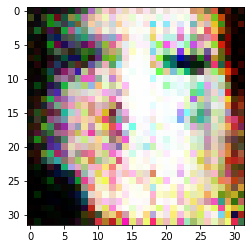

In [70]:
LEVEL_NOISE = 0.3

error_d_m1, error_g_m1, prediccion_falsa_m1 = entrenar(gan1, 3000, 150, "resultadosGAN-7")

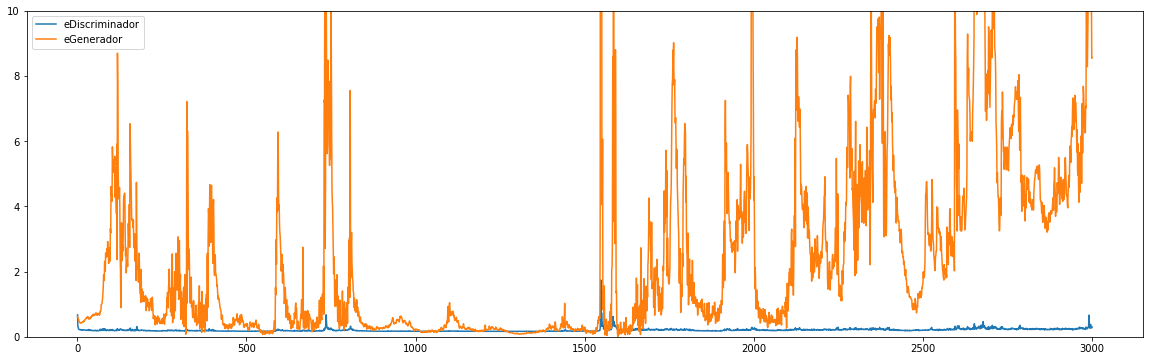

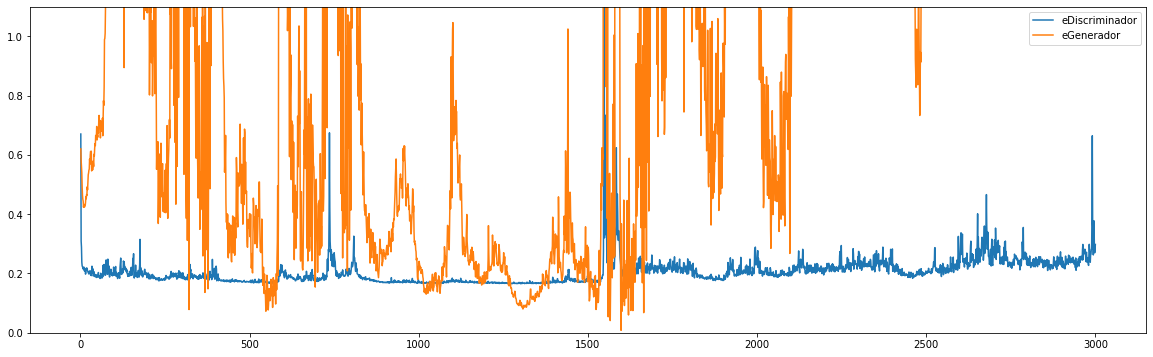

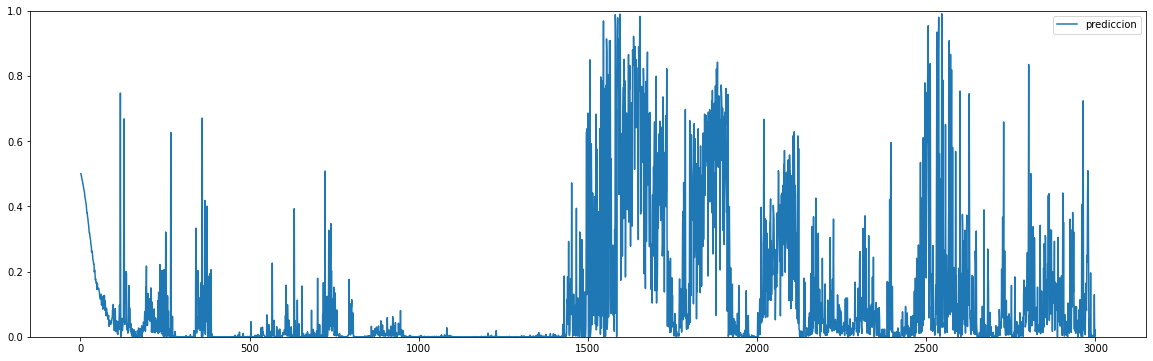

In [71]:
plot_acumulado(len(error_d_m1), 10, eDiscriminador = error_d_m1, eGenerador = error_g_m1)
plot_acumulado(len(error_d_m1), 1.1, eDiscriminador = error_d_m1, eGenerador = error_g_m1)
plot_acumulado(len(prediccion_falsa_m1), 1, prediccion = prediccion_falsa_m1)

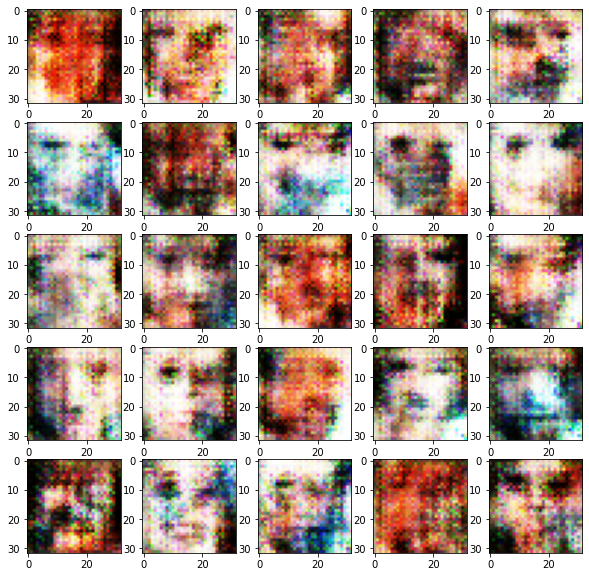

In [137]:
visualizarMosaico(gan1, 5, 5)

tf.Tensor([[0.02241272]], shape=(1, 1), dtype=float32)


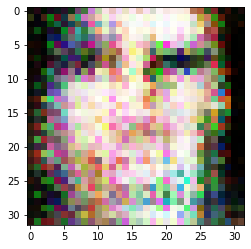

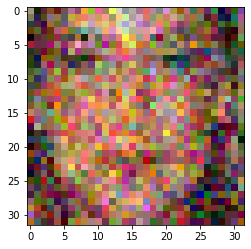

In [91]:
ruido = np.random.normal(0, 1, TAM_ENTRADA)
ruido =np.array([ruido])

predicion(gan1, ruido)

idx = np.random.randint(low=0, high=x_train.shape[0])
img_dataSet = x_train[idx]       
img_dataSet = img_dataSet + LEVEL_NOISE * np.random.normal(loc=0.0, scale=1.0, size=img_dataSet.shape)
img_dataSet = np.clip(img_dataSet, -1, 1)

visualizar_imagen(img_dataSet)


El modelo genera malas imagenes pero no estan muy alejadas a las imagenes con ruido del dataset

### Segundo modelo

A raiz que las imagenes del generador son similares a las del dataset con ruido, vamos a cambiar el entrenamiento para que redusca el ruido a medida que avance. Vamos a hacer un primer tercio con ruido de 0.3, un segundo tercio con ruido de 0.1, y un ultimo tercio sin ruido

In [94]:
def entrenar(GAN, ITERACIONES, TAM_LOTE, CARPETAGUARDADO, GUARDAR_IMG = 100):
    
    generador = GAN.layers[0]
    discriminador = GAN.layers[1]
    error_d_acumulado = np.array([])
    error_g_acumulado = np.array([])
    prediccion_falsa = np.array([])
    
    for i in range(1, ITERACIONES+1):
        
        LEVEL_NOISE = 0.3
        
        if(i/ITERACIONES > 0.3):
            LEVEL_NOISE = 0.1
        elif(i/ITERACIONES > 0.6):
            LEVEL_NOISE = 0
        
        start = time.time()
        print("Comenzando Epoca " + str(i) + ".Ruido:" + str(LEVEL_NOISE), end = "")

        # Crear un "batch" de imágenes falsas y otro con imágenes reales
        ruido = np.random.normal(0, 1, [TAM_LOTE, TAM_ENTRADA])
        batch_falsas = generador.predict(ruido)

        idx = np.random.randint(low=0, high=x_train.shape[0], size= TAM_LOTE)
        batch_reales = x_train[idx]
        
         # Agregamos ruidos a las imagenes segun el LEVEL_NOISE
        batch_reales = batch_reales + LEVEL_NOISE * np.random.normal(loc=0.0, scale=1.0, size=batch_reales.shape)

        # lo ajustamos para que no pase del rango (-1, 1)
        batch_reales = np.clip(batch_reales, -1, 1)

        #la unificacion del batch de entrenamiento es lo que logra que el modelo aprenda
        batch = np.concatenate((batch_reales, batch_falsas))

        #las reales le digo como resultado 1 con np.ones (el 0.9 ayuda a que converga mejor)
        #las falsas le digo como resultado 0 con np.zeros
        valores = np.concatenate((np.ones(TAM_LOTE)*0.9, np.zeros(TAM_LOTE)))

        print(".", end = "")

        discriminador.trainable = True

        # Entrenar discriminador con imagener falsas y reales
        dError = discriminador.train_on_batch(batch, valores)

        error_d_acumulado = np.append(error_d_acumulado, dError)

        #congelo el discriminador
        discriminador.trainable = False

        print(".", end = "")

        # Entrenar GAN: se generará ruido aleatorio y se presentará a la GAN como si fuesen imagenes reales
        ruido = np.random.normal(0, 1, [TAM_LOTE, TAM_ENTRADA])
        gError = GAN.train_on_batch(ruido, np.ones(TAM_LOTE))
            
        error_g_acumulado = np.append(error_g_acumulado, gError)

        print(".", end = "")

        #Cada 100 iteraciones vamos a guardar una imagen
        if i==1 or i%GUARDAR_IMG == 0:
            ruido = np.random.normal(0, 1, TAM_ENTRADA)
            ruido = np.array([ruido])
            resultado = generador.predict(ruido)
            resultado = resultado * 0.5 + 0.5
            plt.imshow(resultado.reshape(TAM_IMG, TAM_IMG, 3))
            plt.savefig(CARPETAGUARDADO + "/r" + str(i) + ".png")

        #hacemos una prueba de prediccion
        ruido = np.random.normal(0, 1, TAM_ENTRADA)
        ruido = np.array([ruido])
        resultado = GAN.predict(ruido)

        prediccion_falsa = np.append(prediccion_falsa, resultado)
        end = time.time()
        print(" Fin")
        print("Tiempo transcurrido: ", round((end - start), 2), "s")
        trm = (ITERACIONES + 1 - i) * (end - start) / 60 #tiempo restante en minutos
        print("Tiempo restante aprox: " + str(round(trm, 2)) + "m -> " + str(int(trm/60)) + ":" + str(int(trm%60)) + "h")
        print("prediccion de ruido: ", resultado)
        print("===================================================================")
     
    return error_d_acumulado, error_g_acumulado, prediccion_falsa

In [95]:
OPTIMIZADOR2 = optimizador.Adam(learning_rate=0.0002, beta_1=0.5) 
ERROR2 = 'binary_crossentropy' 

gan2 = crear_GAN(OPTIMIZADOR2, ERROR2)

Generador Creado
Discriminador Creado
GAN Creado


Comenzando Epoca 1.Ruido:0.3... Fin
Tiempo transcurrido:  4.11 s
Tiempo restante aprox: 205.6m -> 3:25h
prediccion de ruido:  [[0.50021476]]
Comenzando Epoca 2.Ruido:0.3... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 131.69m -> 2:11h
prediccion de ruido:  [[0.49620312]]
Comenzando Epoca 3.Ruido:0.3... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 129.15m -> 2:9h
prediccion de ruido:  [[0.49151042]]
Comenzando Epoca 4.Ruido:0.3... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 130.41m -> 2:10h
prediccion de ruido:  [[0.48495114]]
Comenzando Epoca 5.Ruido:0.3... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 130.57m -> 2:10h
prediccion de ruido:  [[0.47901204]]
Comenzando Epoca 6.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 126.19m -> 2:6h
prediccion de ruido:  [[0.47178316]]
Comenzando Epoca 7.Ruido:0.3... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 129.19m -> 2:9h
prediccion de ruido:  [[0.46621242]]
Comenzando

Comenzando Epoca 79.Ruido:0.3... Fin
Tiempo transcurrido:  2.77 s
Tiempo restante aprox: 134.89m -> 2:14h
prediccion de ruido:  [[0.05255181]]
Comenzando Epoca 80.Ruido:0.3... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 126.83m -> 2:6h
prediccion de ruido:  [[0.03981283]]
Comenzando Epoca 81.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 123.8m -> 2:3h
prediccion de ruido:  [[0.04850748]]
Comenzando Epoca 82.Ruido:0.3... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 126.04m -> 2:6h
prediccion de ruido:  [[0.05738023]]
Comenzando Epoca 83.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 123.67m -> 2:3h
prediccion de ruido:  [[0.03453827]]
Comenzando Epoca 84.Ruido:0.3... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 127.42m -> 2:7h
prediccion de ruido:  [[0.05452111]]
Comenzando Epoca 85.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 123.58m -> 2:3h
prediccion de ruido:  [[0.05671579]]
Comenz

Comenzando Epoca 118.Ruido:0.3... Fin
Tiempo transcurrido:  2.85 s
Tiempo restante aprox: 136.78m -> 2:16h
prediccion de ruido:  [[0.4772804]]
Comenzando Epoca 119.Ruido:0.3... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 132.17m -> 2:12h
prediccion de ruido:  [[0.20823416]]
Comenzando Epoca 120.Ruido:0.3... Fin
Tiempo transcurrido:  2.88 s
Tiempo restante aprox: 138.51m -> 2:18h
prediccion de ruido:  [[0.46510792]]
Comenzando Epoca 121.Ruido:0.3... Fin
Tiempo transcurrido:  2.8 s
Tiempo restante aprox: 134.35m -> 2:14h
prediccion de ruido:  [[0.3599752]]
Comenzando Epoca 122.Ruido:0.3... Fin
Tiempo transcurrido:  2.85 s
Tiempo restante aprox: 136.71m -> 2:16h
prediccion de ruido:  [[0.16733631]]
Comenzando Epoca 123.Ruido:0.3... Fin
Tiempo transcurrido:  2.79 s
Tiempo restante aprox: 133.9m -> 2:13h
prediccion de ruido:  [[0.21314901]]
Comenzando Epoca 124.Ruido:0.3... Fin
Tiempo transcurrido:  2.87 s
Tiempo restante aprox: 137.78m -> 2:17h
prediccion de ruido:  [[0.3271705

Comenzando Epoca 157.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 119.79m -> 1:59h
prediccion de ruido:  [[0.00346786]]
Comenzando Epoca 158.Ruido:0.3... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 121.97m -> 2:1h
prediccion de ruido:  [[0.01011923]]
Comenzando Epoca 159.Ruido:0.3... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 118.97m -> 1:58h
prediccion de ruido:  [[0.00156164]]
Comenzando Epoca 160.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 119.67m -> 1:59h
prediccion de ruido:  [[0.00385463]]
Comenzando Epoca 161.Ruido:0.3... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 118.89m -> 1:58h
prediccion de ruido:  [[0.00475642]]
Comenzando Epoca 162.Ruido:0.3... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 118.89m -> 1:58h
prediccion de ruido:  [[0.00021815]]
Comenzando Epoca 163.Ruido:0.3... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 118.9m -> 1:58h
prediccion de ruido:  [[0.00018

Comenzando Epoca 196.Ruido:0.3... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 117.42m -> 1:57h
prediccion de ruido:  [[0.00072643]]
Comenzando Epoca 197.Ruido:0.3... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 116.65m -> 1:56h
prediccion de ruido:  [[0.00046226]]
Comenzando Epoca 198.Ruido:0.3... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 117.34m -> 1:57h
prediccion de ruido:  [[0.0028646]]
Comenzando Epoca 199.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 118.02m -> 1:58h
prediccion de ruido:  [[0.00132871]]
Comenzando Epoca 200.Ruido:0.3... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 122.49m -> 2:2h
prediccion de ruido:  [[0.00691941]]
Comenzando Epoca 201.Ruido:0.3... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 119.39m -> 1:59h
prediccion de ruido:  [[0.00232956]]
Comenzando Epoca 202.Ruido:0.3... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 119.35m -> 1:59h
prediccion de ruido:  [[0.002287

Comenzando Epoca 235.Ruido:0.3... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 117.94m -> 1:57h
prediccion de ruido:  [[0.0528048]]
Comenzando Epoca 236.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 117.18m -> 1:57h
prediccion de ruido:  [[0.1004996]]
Comenzando Epoca 237.Ruido:0.3... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 117.86m -> 1:57h
prediccion de ruido:  [[0.1402168]]
Comenzando Epoca 238.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 117.1m -> 1:57h
prediccion de ruido:  [[0.06291586]]
Comenzando Epoca 239.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 117.06m -> 1:57h
prediccion de ruido:  [[0.07694528]]
Comenzando Epoca 240.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 117.01m -> 1:57h
prediccion de ruido:  [[0.21693215]]
Comenzando Epoca 241.Ruido:0.3... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 118.5m -> 1:58h
prediccion de ruido:  [[0.1418908]

Comenzando Epoca 274.Ruido:0.3... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 124.13m -> 2:4h
prediccion de ruido:  [[0.00043783]]
Comenzando Epoca 275.Ruido:0.3... Fin
Tiempo transcurrido:  2.74 s
Tiempo restante aprox: 124.39m -> 2:4h
prediccion de ruido:  [[0.00357172]]
Comenzando Epoca 276.Ruido:0.3... Fin
Tiempo transcurrido:  2.74 s
Tiempo restante aprox: 124.39m -> 2:4h
prediccion de ruido:  [[0.03841466]]
Comenzando Epoca 277.Ruido:0.3... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 121.72m -> 2:1h
prediccion de ruido:  [[0.0008873]]
Comenzando Epoca 278.Ruido:0.3... Fin
Tiempo transcurrido:  2.85 s
Tiempo restante aprox: 129.26m -> 2:9h
prediccion de ruido:  [[0.01860613]]
Comenzando Epoca 279.Ruido:0.3... Fin
Tiempo transcurrido:  2.78 s
Tiempo restante aprox: 126.24m -> 2:6h
prediccion de ruido:  [[0.00071022]]
Comenzando Epoca 280.Ruido:0.3... Fin
Tiempo transcurrido:  2.79 s
Tiempo restante aprox: 126.66m -> 2:6h
prediccion de ruido:  [[0.00030375]]


Comenzando Epoca 313.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 113.96m -> 1:53h
prediccion de ruido:  [[5.3354237e-18]]
Comenzando Epoca 314.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 113.37m -> 1:53h
prediccion de ruido:  [[2.4235835e-13]]
Comenzando Epoca 315.Ruido:0.3... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 112.3m -> 1:52h
prediccion de ruido:  [[1.3403181e-09]]
Comenzando Epoca 316.Ruido:0.3... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 112.64m -> 1:52h
prediccion de ruido:  [[1.1143209e-09]]
Comenzando Epoca 317.Ruido:0.3... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 122.09m -> 2:2h
prediccion de ruido:  [[8.771652e-09]]
Comenzando Epoca 318.Ruido:0.3... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 116.36m -> 1:56h
prediccion de ruido:  [[1.0682494e-07]]
Comenzando Epoca 319.Ruido:0.3... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 113.83m -> 1:53h
prediccion de r

Comenzando Epoca 352.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 111.58m -> 1:51h
prediccion de ruido:  [[0.05723441]]
Comenzando Epoca 353.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 111.54m -> 1:51h
prediccion de ruido:  [[0.06135273]]
Comenzando Epoca 354.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 111.49m -> 1:51h
prediccion de ruido:  [[0.81520414]]
Comenzando Epoca 355.Ruido:0.3... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 113.39m -> 1:53h
prediccion de ruido:  [[0.10254219]]
Comenzando Epoca 356.Ruido:0.3... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 113.08m -> 1:53h
prediccion de ruido:  [[0.20773923]]
Comenzando Epoca 357.Ruido:0.3... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 112.83m -> 1:52h
prediccion de ruido:  [[0.28511542]]
Comenzando Epoca 358.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 112.06m -> 1:52h
prediccion de ruido:  [[0.327

Comenzando Epoca 391.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 109.93m -> 1:49h
prediccion de ruido:  [[0.35802612]]
Comenzando Epoca 392.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 109.89m -> 1:49h
prediccion de ruido:  [[0.13312054]]
Comenzando Epoca 393.Ruido:0.3... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 109.17m -> 1:49h
prediccion de ruido:  [[0.02960822]]
Comenzando Epoca 394.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 109.81m -> 1:49h
prediccion de ruido:  [[0.02887991]]
Comenzando Epoca 395.Ruido:0.3... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 109.26m -> 1:49h
prediccion de ruido:  [[0.11719471]]
Comenzando Epoca 396.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 109.85m -> 1:49h
prediccion de ruido:  [[0.03091341]]
Comenzando Epoca 397.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 109.68m -> 1:49h
prediccion de ruido:  [[0.031

Comenzando Epoca 430.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 108.2m -> 1:48h
prediccion de ruido:  [[0.15049532]]
Comenzando Epoca 431.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 108.96m -> 1:48h
prediccion de ruido:  [[0.13127992]]
Comenzando Epoca 432.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 108.81m -> 1:48h
prediccion de ruido:  [[0.22492212]]
Comenzando Epoca 433.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 108.08m -> 1:48h
prediccion de ruido:  [[0.14586133]]
Comenzando Epoca 434.Ruido:0.3... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 109.42m -> 1:49h
prediccion de ruido:  [[0.3481878]]
Comenzando Epoca 435.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 108.72m -> 1:48h
prediccion de ruido:  [[0.02232149]]
Comenzando Epoca 436.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 108.42m -> 1:48h
prediccion de ruido:  [[0.02511

Comenzando Epoca 469.Ruido:0.3... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 108.35m -> 1:48h
prediccion de ruido:  [[0.02145624]]
Comenzando Epoca 470.Ruido:0.3... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 108.05m -> 1:48h
prediccion de ruido:  [[0.00735545]]
Comenzando Epoca 471.Ruido:0.3... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 109.18m -> 1:49h
prediccion de ruido:  [[0.00496429]]
Comenzando Epoca 472.Ruido:0.3... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 109.42m -> 1:49h
prediccion de ruido:  [[0.00114882]]
Comenzando Epoca 473.Ruido:0.3... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 108.68m -> 1:48h
prediccion de ruido:  [[0.10165694]]
Comenzando Epoca 474.Ruido:0.3... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 108.42m -> 1:48h
prediccion de ruido:  [[0.00248325]]
Comenzando Epoca 475.Ruido:0.3... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 110.3m -> 1:50h
prediccion de ruido:  [[0.00307

Comenzando Epoca 508.Ruido:0.3... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 107.0m -> 1:47h
prediccion de ruido:  [[0.00804397]]
Comenzando Epoca 509.Ruido:0.3... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 112.09m -> 1:52h
prediccion de ruido:  [[0.05081165]]
Comenzando Epoca 510.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 105.52m -> 1:45h
prediccion de ruido:  [[0.03055412]]
Comenzando Epoca 511.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 104.94m -> 1:44h
prediccion de ruido:  [[0.03395945]]
Comenzando Epoca 512.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 105.15m -> 1:45h
prediccion de ruido:  [[0.09790513]]
Comenzando Epoca 513.Ruido:0.3... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 107.23m -> 1:47h
prediccion de ruido:  [[0.01541236]]
Comenzando Epoca 514.Ruido:0.3... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 105.75m -> 1:45h
prediccion de ruido:  [[0.16805

Comenzando Epoca 547.Ruido:0.3... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 110.98m -> 1:50h
prediccion de ruido:  [[0.27052695]]
Comenzando Epoca 548.Ruido:0.3... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 112.26m -> 1:52h
prediccion de ruido:  [[0.29950565]]
Comenzando Epoca 549.Ruido:0.3... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 110.93m -> 1:50h
prediccion de ruido:  [[0.09512168]]
Comenzando Epoca 550.Ruido:0.3... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 112.16m -> 1:52h
prediccion de ruido:  [[0.20123884]]
Comenzando Epoca 551.Ruido:0.3... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 110.2m -> 1:50h
prediccion de ruido:  [[0.25744814]]
Comenzando Epoca 552.Ruido:0.3... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 110.16m -> 1:50h
prediccion de ruido:  [[0.15386003]]
Comenzando Epoca 553.Ruido:0.3... Fin
Tiempo transcurrido:  2.76 s
Tiempo restante aprox: 112.66m -> 1:52h
prediccion de ruido:  [[0.143071

Comenzando Epoca 586.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 102.07m -> 1:42h
prediccion de ruido:  [[0.2314898]]
Comenzando Epoca 587.Ruido:0.3... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 102.46m -> 1:42h
prediccion de ruido:  [[0.13499641]]
Comenzando Epoca 588.Ruido:0.3... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 102.91m -> 1:42h
prediccion de ruido:  [[0.11453286]]
Comenzando Epoca 589.Ruido:0.3... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 101.48m -> 1:41h
prediccion de ruido:  [[0.3031849]]
Comenzando Epoca 590.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 102.23m -> 1:42h
prediccion de ruido:  [[0.06517768]]
Comenzando Epoca 591.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 102.17m -> 1:42h
prediccion de ruido:  [[0.20637402]]
Comenzando Epoca 592.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 101.42m -> 1:41h
prediccion de ruido:  [[0.07550

Comenzando Epoca 625.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 100.62m -> 1:40h
prediccion de ruido:  [[0.04887217]]
Comenzando Epoca 626.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 100.63m -> 1:40h
prediccion de ruido:  [[0.3689325]]
Comenzando Epoca 627.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 100.56m -> 1:40h
prediccion de ruido:  [[0.09487399]]
Comenzando Epoca 628.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 100.01m -> 1:40h
prediccion de ruido:  [[0.04979628]]
Comenzando Epoca 629.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 100.3m -> 1:40h
prediccion de ruido:  [[0.01033491]]
Comenzando Epoca 630.Ruido:0.3... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 100.62m -> 1:40h
prediccion de ruido:  [[0.01538444]]
Comenzando Epoca 631.Ruido:0.3... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 99.68m -> 1:39h
prediccion de ruido:  [[0.069781

Comenzando Epoca 664.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 99.04m -> 1:39h
prediccion de ruido:  [[0.35104463]]
Comenzando Epoca 665.Ruido:0.3... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 97.79m -> 1:37h
prediccion de ruido:  [[0.18511614]]
Comenzando Epoca 666.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 98.47m -> 1:38h
prediccion de ruido:  [[0.10062149]]
Comenzando Epoca 667.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 98.31m -> 1:38h
prediccion de ruido:  [[0.09659851]]
Comenzando Epoca 668.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 98.27m -> 1:38h
prediccion de ruido:  [[0.06565028]]
Comenzando Epoca 669.Ruido:0.3... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 100.72m -> 1:40h
prediccion de ruido:  [[0.26485956]]
Comenzando Epoca 670.Ruido:0.3... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 104.84m -> 1:44h
prediccion de ruido:  [[0.28229952]

Comenzando Epoca 703.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 96.96m -> 1:36h
prediccion de ruido:  [[0.11694872]]
Comenzando Epoca 704.Ruido:0.3... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 97.86m -> 1:37h
prediccion de ruido:  [[0.15594918]]
Comenzando Epoca 705.Ruido:0.3... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 97.77m -> 1:37h
prediccion de ruido:  [[0.03800771]]
Comenzando Epoca 706.Ruido:0.3... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 99.42m -> 1:39h
prediccion de ruido:  [[0.10946694]]
Comenzando Epoca 707.Ruido:0.3... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 99.64m -> 1:39h
prediccion de ruido:  [[0.4598292]]
Comenzando Epoca 708.Ruido:0.3... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 100.15m -> 1:40h
prediccion de ruido:  [[0.02851206]]
Comenzando Epoca 709.Ruido:0.3... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 101.25m -> 1:41h
prediccion de ruido:  [[0.03039598]]

Comenzando Epoca 742.Ruido:0.3... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 102.33m -> 1:42h
prediccion de ruido:  [[0.00027132]]
Comenzando Epoca 743.Ruido:0.3... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 101.89m -> 1:41h
prediccion de ruido:  [[0.0056273]]
Comenzando Epoca 744.Ruido:0.3... Fin
Tiempo transcurrido:  2.84 s
Tiempo restante aprox: 106.98m -> 1:46h
prediccion de ruido:  [[0.00838745]]
Comenzando Epoca 745.Ruido:0.3... Fin
Tiempo transcurrido:  2.76 s
Tiempo restante aprox: 103.9m -> 1:43h
prediccion de ruido:  [[0.02219003]]
Comenzando Epoca 746.Ruido:0.3... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 97.82m -> 1:37h
prediccion de ruido:  [[0.00520653]]
Comenzando Epoca 747.Ruido:0.3... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 94.83m -> 1:34h
prediccion de ruido:  [[0.04625976]]
Comenzando Epoca 748.Ruido:0.3... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 99.25m -> 1:39h
prediccion de ruido:  [[0.00361994]

Comenzando Epoca 781.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 94.0m -> 1:33h
prediccion de ruido:  [[0.00293577]]
Comenzando Epoca 782.Ruido:0.3... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 99.09m -> 1:39h
prediccion de ruido:  [[0.0177649]]
Comenzando Epoca 783.Ruido:0.3... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 96.26m -> 1:36h
prediccion de ruido:  [[0.00398651]]
Comenzando Epoca 784.Ruido:0.3... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 99.77m -> 1:39h
prediccion de ruido:  [[0.00414509]]
Comenzando Epoca 785.Ruido:0.3... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 96.95m -> 1:36h
prediccion de ruido:  [[0.00198877]]
Comenzando Epoca 786.Ruido:0.3... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 94.06m -> 1:34h
prediccion de ruido:  [[0.00124413]]
Comenzando Epoca 787.Ruido:0.3... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 95.2m -> 1:35h
prediccion de ruido:  [[0.01646844]]
Come

Comenzando Epoca 820.Ruido:0.3... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 94.3m -> 1:34h
prediccion de ruido:  [[0.29973066]]
Comenzando Epoca 821.Ruido:0.3... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 97.35m -> 1:37h
prediccion de ruido:  [[0.13253346]]
Comenzando Epoca 822.Ruido:0.3... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 99.04m -> 1:39h
prediccion de ruido:  [[0.14155361]]
Comenzando Epoca 823.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 91.78m -> 1:31h
prediccion de ruido:  [[0.5780501]]
Comenzando Epoca 824.Ruido:0.3... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 94.31m -> 1:34h
prediccion de ruido:  [[0.42342728]]
Comenzando Epoca 825.Ruido:0.3... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 91.31m -> 1:31h
prediccion de ruido:  [[0.4221582]]
Comenzando Epoca 826.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 91.76m -> 1:31h
prediccion de ruido:  [[0.16864079]]
Com

Comenzando Epoca 859.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 90.22m -> 1:30h
prediccion de ruido:  [[0.0892199]]
Comenzando Epoca 860.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 90.18m -> 1:30h
prediccion de ruido:  [[0.05218387]]
Comenzando Epoca 861.Ruido:0.3... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 89.58m -> 1:29h
prediccion de ruido:  [[0.17784765]]
Comenzando Epoca 862.Ruido:0.3... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 92.06m -> 1:32h
prediccion de ruido:  [[0.4259513]]
Comenzando Epoca 863.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 90.05m -> 1:30h
prediccion de ruido:  [[0.00069606]]
Comenzando Epoca 864.Ruido:0.3... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 89.46m -> 1:29h
prediccion de ruido:  [[0.00682163]]
Comenzando Epoca 865.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 90.53m -> 1:30h
prediccion de ruido:  [[0.01016563]]
C

Comenzando Epoca 898.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 88.58m -> 1:28h
prediccion de ruido:  [[0.06122613]]
Comenzando Epoca 899.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 88.54m -> 1:28h
prediccion de ruido:  [[0.0881983]]
Comenzando Epoca 900.Ruido:0.3... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 96.18m -> 1:36h
prediccion de ruido:  [[0.02549624]]
Comenzando Epoca 901.Ruido:0.1... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 94.04m -> 1:34h
prediccion de ruido:  [[5.5834107e-06]]
Comenzando Epoca 902.Ruido:0.1... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 92.17m -> 1:32h
prediccion de ruido:  [[8.761579e-05]]
Comenzando Epoca 903.Ruido:0.1... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 91.91m -> 1:31h
prediccion de ruido:  [[4.7292633e-05]]
Comenzando Epoca 904.Ruido:0.1... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 89.64m -> 1:29h
prediccion de ruido:  [[2.756

Comenzando Epoca 937.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 86.94m -> 1:26h
prediccion de ruido:  [[0.04186195]]
Comenzando Epoca 938.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 86.36m -> 1:26h
prediccion de ruido:  [[0.03600252]]
Comenzando Epoca 939.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 86.39m -> 1:26h
prediccion de ruido:  [[0.04483342]]
Comenzando Epoca 940.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 86.34m -> 1:26h
prediccion de ruido:  [[0.00889507]]
Comenzando Epoca 941.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 86.23m -> 1:26h
prediccion de ruido:  [[0.1741823]]
Comenzando Epoca 942.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 86.19m -> 1:26h
prediccion de ruido:  [[0.11509755]]
Comenzando Epoca 943.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 86.15m -> 1:26h
prediccion de ruido:  [[0.00635093]]


Comenzando Epoca 976.Ruido:0.1... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 92.91m -> 1:32h
prediccion de ruido:  [[0.02320889]]
Comenzando Epoca 977.Ruido:0.1... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 87.54m -> 1:27h
prediccion de ruido:  [[0.38769922]]
Comenzando Epoca 978.Ruido:0.1... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 87.75m -> 1:27h
prediccion de ruido:  [[0.1173093]]
Comenzando Epoca 979.Ruido:0.1... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 86.34m -> 1:26h
prediccion de ruido:  [[0.13343534]]
Comenzando Epoca 980.Ruido:0.1... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 86.99m -> 1:26h
prediccion de ruido:  [[0.02111694]]
Comenzando Epoca 981.Ruido:0.1... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 87.5m -> 1:27h
prediccion de ruido:  [[0.01787081]]
Comenzando Epoca 982.Ruido:0.1... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 87.53m -> 1:27h
prediccion de ruido:  [[0.04779562]]
Comen

Comenzando Epoca 1015.Ruido:0.1... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 85.3m -> 1:25h
prediccion de ruido:  [[0.06872872]]
Comenzando Epoca 1016.Ruido:0.1... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 86.33m -> 1:26h
prediccion de ruido:  [[0.20479527]]
Comenzando Epoca 1017.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 83.98m -> 1:23h
prediccion de ruido:  [[0.2073994]]
Comenzando Epoca 1018.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 84.09m -> 1:24h
prediccion de ruido:  [[0.04780135]]
Comenzando Epoca 1019.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 83.96m -> 1:23h
prediccion de ruido:  [[0.42328563]]
Comenzando Epoca 1020.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 83.38m -> 1:23h
prediccion de ruido:  [[0.44984415]]
Comenzando Epoca 1021.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 83.33m -> 1:23h
prediccion de ruido:  [[0.56910

Comenzando Epoca 1054.Ruido:0.1... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 83.02m -> 1:23h
prediccion de ruido:  [[0.179495]]
Comenzando Epoca 1055.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 82.47m -> 1:22h
prediccion de ruido:  [[0.07299528]]
Comenzando Epoca 1056.Ruido:0.1... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 82.94m -> 1:22h
prediccion de ruido:  [[0.06901026]]
Comenzando Epoca 1057.Ruido:0.1... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 82.96m -> 1:22h
prediccion de ruido:  [[0.4870283]]
Comenzando Epoca 1058.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 81.4m -> 1:21h
prediccion de ruido:  [[0.072117]]
Comenzando Epoca 1059.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 81.39m -> 1:21h
prediccion de ruido:  [[0.07753518]]
Comenzando Epoca 1060.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 81.25m -> 1:21h
prediccion de ruido:  [[0.4807877]]

Comenzando Epoca 1093.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 80.37m -> 1:20h
prediccion de ruido:  [[0.5775853]]
Comenzando Epoca 1094.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 80.32m -> 1:20h
prediccion de ruido:  [[0.12584233]]
Comenzando Epoca 1095.Ruido:0.1... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 81.77m -> 1:21h
prediccion de ruido:  [[0.414863]]
Comenzando Epoca 1096.Ruido:0.1... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 83.71m -> 1:23h
prediccion de ruido:  [[0.16716126]]
Comenzando Epoca 1097.Ruido:0.1... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 85.81m -> 1:25h
prediccion de ruido:  [[0.03549033]]
Comenzando Epoca 1098.Ruido:0.1... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 84.21m -> 1:24h
prediccion de ruido:  [[0.8168812]]
Comenzando Epoca 1099.Ruido:0.1... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 81.1m -> 1:21h
prediccion de ruido:  [[0.6518965]]

Comenzando Epoca 1132.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 78.24m -> 1:18h
prediccion de ruido:  [[0.44263503]]
Comenzando Epoca 1133.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 78.29m -> 1:18h
prediccion de ruido:  [[0.7124986]]
Comenzando Epoca 1134.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 78.64m -> 1:18h
prediccion de ruido:  [[0.63682806]]
Comenzando Epoca 1135.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 78.6m -> 1:18h
prediccion de ruido:  [[0.26198027]]
Comenzando Epoca 1136.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 78.07m -> 1:18h
prediccion de ruido:  [[0.08676445]]
Comenzando Epoca 1137.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 78.51m -> 1:18h
prediccion de ruido:  [[0.00881746]]
Comenzando Epoca 1138.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 77.99m -> 1:17h
prediccion de ruido:  [[0.14286

Comenzando Epoca 1171.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 77.14m -> 1:17h
prediccion de ruido:  [[0.09509629]]
Comenzando Epoca 1172.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 76.56m -> 1:16h
prediccion de ruido:  [[0.36573339]]
Comenzando Epoca 1173.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 76.52m -> 1:16h
prediccion de ruido:  [[0.00037035]]
Comenzando Epoca 1174.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 76.48m -> 1:16h
prediccion de ruido:  [[0.01719636]]
Comenzando Epoca 1175.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 76.91m -> 1:16h
prediccion de ruido:  [[0.5151428]]
Comenzando Epoca 1176.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 76.4m -> 1:16h
prediccion de ruido:  [[0.0052833]]
Comenzando Epoca 1177.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 76.83m -> 1:16h
prediccion de ruido:  [[0.199677

Comenzando Epoca 1210.Ruido:0.1... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 78.23m -> 1:18h
prediccion de ruido:  [[7.752825e-08]]
Comenzando Epoca 1211.Ruido:0.1... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 76.1m -> 1:16h
prediccion de ruido:  [[4.6954497e-07]]
Comenzando Epoca 1212.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 74.92m -> 1:14h
prediccion de ruido:  [[4.039295e-08]]
Comenzando Epoca 1213.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 74.85m -> 1:14h
prediccion de ruido:  [[1.3170969e-05]]
Comenzando Epoca 1214.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 75.27m -> 1:15h
prediccion de ruido:  [[2.0961335e-07]]
Comenzando Epoca 1215.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 74.76m -> 1:14h
prediccion de ruido:  [[7.516149e-05]]
Comenzando Epoca 1216.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 75.18m -> 1:15h
prediccion de r

Comenzando Epoca 1249.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 73.79m -> 1:13h
prediccion de ruido:  [[0.05850708]]
Comenzando Epoca 1250.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 73.71m -> 1:13h
prediccion de ruido:  [[0.34428114]]
Comenzando Epoca 1251.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 73.26m -> 1:13h
prediccion de ruido:  [[0.71224165]]
Comenzando Epoca 1252.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 74.12m -> 1:14h
prediccion de ruido:  [[0.7724929]]
Comenzando Epoca 1253.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 73.63m -> 1:13h
prediccion de ruido:  [[0.27289906]]
Comenzando Epoca 1254.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 73.58m -> 1:13h
prediccion de ruido:  [[0.19053236]]
Comenzando Epoca 1255.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 73.09m -> 1:13h
prediccion de ruido:  [[0.0505

Comenzando Epoca 1288.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 71.76m -> 1:11h
prediccion de ruido:  [[0.523359]]
Comenzando Epoca 1289.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 72.14m -> 1:12h
prediccion de ruido:  [[0.21309364]]
Comenzando Epoca 1290.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 72.07m -> 1:12h
prediccion de ruido:  [[0.8907266]]
Comenzando Epoca 1291.Ruido:0.1... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 72.91m -> 1:12h
prediccion de ruido:  [[0.69028413]]
Comenzando Epoca 1292.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 71.98m -> 1:11h
prediccion de ruido:  [[0.11247981]]
Comenzando Epoca 1293.Ruido:0.1... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 73.27m -> 1:13h
prediccion de ruido:  [[0.3841256]]
Comenzando Epoca 1294.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 71.9m -> 1:11h
prediccion de ruido:  [[0.7570816]

Comenzando Epoca 1327.Ruido:0.1... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 71.5m -> 1:11h
prediccion de ruido:  [[0.6998297]]
Comenzando Epoca 1328.Ruido:0.1... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 73.15m -> 1:13h
prediccion de ruido:  [[0.3940961]]
Comenzando Epoca 1329.Ruido:0.1... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 71.58m -> 1:11h
prediccion de ruido:  [[0.77437174]]
Comenzando Epoca 1330.Ruido:0.1... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 72.01m -> 1:12h
prediccion de ruido:  [[0.5049658]]
Comenzando Epoca 1331.Ruido:0.1... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 71.21m -> 1:11h
prediccion de ruido:  [[0.41673553]]
Comenzando Epoca 1332.Ruido:0.1... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 72.63m -> 1:12h
prediccion de ruido:  [[0.45710373]]
Comenzando Epoca 1333.Ruido:0.1... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 73.1m -> 1:13h
prediccion de ruido:  [[0.3014058]

Comenzando Epoca 1366.Ruido:0.1... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 69.77m -> 1:9h
prediccion de ruido:  [[0.51674616]]
Comenzando Epoca 1367.Ruido:0.1... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 71.62m -> 1:11h
prediccion de ruido:  [[0.53114384]]
Comenzando Epoca 1368.Ruido:0.1... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 70.6m -> 1:10h
prediccion de ruido:  [[0.53624475]]
Comenzando Epoca 1369.Ruido:0.1... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 71.14m -> 1:11h
prediccion de ruido:  [[0.42115277]]
Comenzando Epoca 1370.Ruido:0.1... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 70.35m -> 1:10h
prediccion de ruido:  [[0.4700896]]
Comenzando Epoca 1371.Ruido:0.1... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 71.45m -> 1:11h
prediccion de ruido:  [[0.34051934]]
Comenzando Epoca 1372.Ruido:0.1... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 70.36m -> 1:10h
prediccion de ruido:  [[0.537322

Comenzando Epoca 1405.Ruido:0.1... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 68.77m -> 1:8h
prediccion de ruido:  [[0.18618965]]
Comenzando Epoca 1406.Ruido:0.1... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 68.8m -> 1:8h
prediccion de ruido:  [[0.28263962]]
Comenzando Epoca 1407.Ruido:0.1... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 68.39m -> 1:8h
prediccion de ruido:  [[0.42487243]]
Comenzando Epoca 1408.Ruido:0.1... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 68.8m -> 1:8h
prediccion de ruido:  [[0.39926663]]
Comenzando Epoca 1409.Ruido:0.1... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 68.47m -> 1:8h
prediccion de ruido:  [[0.19453365]]
Comenzando Epoca 1410.Ruido:0.1... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 68.79m -> 1:8h
prediccion de ruido:  [[0.17440426]]
Comenzando Epoca 1411.Ruido:0.1... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 69.23m -> 1:9h
prediccion de ruido:  [[0.10433164]]
C

Comenzando Epoca 1444.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 65.9m -> 1:5h
prediccion de ruido:  [[0.0108971]]
Comenzando Epoca 1445.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 65.89m -> 1:5h
prediccion de ruido:  [[0.10258213]]
Comenzando Epoca 1446.Ruido:0.1... Fin
Tiempo transcurrido:  2.78 s
Tiempo restante aprox: 72.16m -> 1:12h
prediccion de ruido:  [[0.04386872]]
Comenzando Epoca 1447.Ruido:0.1... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 66.82m -> 1:6h
prediccion de ruido:  [[0.2718154]]
Comenzando Epoca 1448.Ruido:0.1... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 67.08m -> 1:7h
prediccion de ruido:  [[0.01221615]]
Comenzando Epoca 1449.Ruido:0.1... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 67.08m -> 1:7h
prediccion de ruido:  [[0.04227167]]
Comenzando Epoca 1450.Ruido:0.1... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 65.97m -> 1:5h
prediccion de ruido:  [[0.08343512]]
C

Comenzando Epoca 1483.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 64.01m -> 1:4h
prediccion de ruido:  [[0.3903368]]
Comenzando Epoca 1484.Ruido:0.1... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 64.43m -> 1:4h
prediccion de ruido:  [[0.00592345]]
Comenzando Epoca 1485.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 64.24m -> 1:4h
prediccion de ruido:  [[0.00870955]]
Comenzando Epoca 1486.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 64.07m -> 1:4h
prediccion de ruido:  [[0.01482147]]
Comenzando Epoca 1487.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 64.15m -> 1:4h
prediccion de ruido:  [[0.0115616]]
Comenzando Epoca 1488.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 63.91m -> 1:3h
prediccion de ruido:  [[0.04774383]]
Comenzando Epoca 1489.Ruido:0.1... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 63.51m -> 1:3h
prediccion de ruido:  [[0.03576913]]
C

Comenzando Epoca 1522.Ruido:0.1... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 63.74m -> 1:3h
prediccion de ruido:  [[0.01075956]]
Comenzando Epoca 1523.Ruido:0.1... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 62.81m -> 1:2h
prediccion de ruido:  [[0.00457153]]
Comenzando Epoca 1524.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 62.47m -> 1:2h
prediccion de ruido:  [[0.01198524]]
Comenzando Epoca 1525.Ruido:0.1... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 63.25m -> 1:3h
prediccion de ruido:  [[0.04747507]]
Comenzando Epoca 1526.Ruido:0.1... Fin
Tiempo transcurrido:  2.76 s
Tiempo restante aprox: 67.85m -> 1:7h
prediccion de ruido:  [[0.06287822]]
Comenzando Epoca 1527.Ruido:0.1... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 64.6m -> 1:4h
prediccion de ruido:  [[0.38367078]]
Comenzando Epoca 1528.Ruido:0.1... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 65.04m -> 1:5h
prediccion de ruido:  [[0.30314863]]


Comenzando Epoca 1561.Ruido:0.1... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 65.57m -> 1:5h
prediccion de ruido:  [[0.23487556]]
Comenzando Epoca 1562.Ruido:0.1... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 61.42m -> 1:1h
prediccion de ruido:  [[0.07837686]]
Comenzando Epoca 1563.Ruido:0.1... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 63.09m -> 1:3h
prediccion de ruido:  [[0.14563078]]
Comenzando Epoca 1564.Ruido:0.1... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 60.46m -> 1:0h
prediccion de ruido:  [[0.1411497]]
Comenzando Epoca 1565.Ruido:0.1... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 62.21m -> 1:2h
prediccion de ruido:  [[0.15170214]]
Comenzando Epoca 1566.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 60.57m -> 1:0h
prediccion de ruido:  [[0.23072594]]
Comenzando Epoca 1567.Ruido:0.1... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 60.27m -> 1:0h
prediccion de ruido:  [[0.01264673]]
C

Comenzando Epoca 1600.Ruido:0.1... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 64.18m -> 1:4h
prediccion de ruido:  [[0.00301805]]
Comenzando Epoca 1601.Ruido:0.1... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 60.41m -> 1:0h
prediccion de ruido:  [[0.00539452]]
Comenzando Epoca 1602.Ruido:0.1... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 60.17m -> 1:0h
prediccion de ruido:  [[0.00217733]]
Comenzando Epoca 1603.Ruido:0.1... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 59.8m -> 0:59h
prediccion de ruido:  [[0.00166199]]
Comenzando Epoca 1604.Ruido:0.1... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 59.65m -> 0:59h
prediccion de ruido:  [[0.00209886]]
Comenzando Epoca 1605.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 59.08m -> 0:59h
prediccion de ruido:  [[0.00164646]]
Comenzando Epoca 1606.Ruido:0.1... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 60.02m -> 1:0h
prediccion de ruido:  [[0.00470948

Comenzando Epoca 1639.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 57.01m -> 0:57h
prediccion de ruido:  [[0.00100619]]
Comenzando Epoca 1640.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 57.33m -> 0:57h
prediccion de ruido:  [[0.00012365]]
Comenzando Epoca 1641.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 57.28m -> 0:57h
prediccion de ruido:  [[0.00063336]]
Comenzando Epoca 1642.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 57.29m -> 0:57h
prediccion de ruido:  [[0.00701088]]
Comenzando Epoca 1643.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 56.89m -> 0:56h
prediccion de ruido:  [[0.00079665]]
Comenzando Epoca 1644.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 56.8m -> 0:56h
prediccion de ruido:  [[0.0001975]]
Comenzando Epoca 1645.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 56.76m -> 0:56h
prediccion de ruido:  [[0.02265

Comenzando Epoca 1678.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 55.72m -> 0:55h
prediccion de ruido:  [[0.01027659]]
Comenzando Epoca 1679.Ruido:0.1... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 59.85m -> 0:59h
prediccion de ruido:  [[0.00542831]]
Comenzando Epoca 1680.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 55.32m -> 0:55h
prediccion de ruido:  [[0.01478013]]
Comenzando Epoca 1681.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 55.6m -> 0:55h
prediccion de ruido:  [[0.06432176]]
Comenzando Epoca 1682.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 55.21m -> 0:55h
prediccion de ruido:  [[0.03714657]]
Comenzando Epoca 1683.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 55.17m -> 0:55h
prediccion de ruido:  [[0.02952686]]
Comenzando Epoca 1684.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 55.17m -> 0:55h
prediccion de ruido:  [[0.0200

Comenzando Epoca 1717.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 54.08m -> 0:54h
prediccion de ruido:  [[0.10036734]]
Comenzando Epoca 1718.Ruido:0.1... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 53.37m -> 0:53h
prediccion de ruido:  [[0.39789516]]
Comenzando Epoca 1719.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 54.0m -> 0:53h
prediccion de ruido:  [[0.05516836]]
Comenzando Epoca 1720.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 53.62m -> 0:53h
prediccion de ruido:  [[0.21597281]]
Comenzando Epoca 1721.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 54.0m -> 0:53h
prediccion de ruido:  [[0.17117137]]
Comenzando Epoca 1722.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 53.54m -> 0:53h
prediccion de ruido:  [[0.07039624]]
Comenzando Epoca 1723.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 53.83m -> 0:53h
prediccion de ruido:  [[0.275610

Comenzando Epoca 1756.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 52.48m -> 0:52h
prediccion de ruido:  [[0.00992289]]
Comenzando Epoca 1757.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 52.4m -> 0:52h
prediccion de ruido:  [[0.02122337]]
Comenzando Epoca 1758.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 52.03m -> 0:52h
prediccion de ruido:  [[0.10312748]]
Comenzando Epoca 1759.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 51.99m -> 0:51h
prediccion de ruido:  [[0.01661286]]
Comenzando Epoca 1760.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 52.59m -> 0:52h
prediccion de ruido:  [[0.03710052]]
Comenzando Epoca 1761.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 51.91m -> 0:51h
prediccion de ruido:  [[0.01375249]]
Comenzando Epoca 1762.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 51.88m -> 0:51h
prediccion de ruido:  [[0.0138

Comenzando Epoca 1795.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 50.8m -> 0:50h
prediccion de ruido:  [[0.03479305]]
Comenzando Epoca 1796.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 50.48m -> 0:50h
prediccion de ruido:  [[0.19287744]]
Comenzando Epoca 1797.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 50.73m -> 0:50h
prediccion de ruido:  [[0.02356544]]
Comenzando Epoca 1798.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 50.36m -> 0:50h
prediccion de ruido:  [[0.00487578]]
Comenzando Epoca 1799.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 50.63m -> 0:50h
prediccion de ruido:  [[0.05106828]]
Comenzando Epoca 1800.Ruido:0.1... Fin
Tiempo transcurrido:  2.73 s
Tiempo restante aprox: 54.67m -> 0:54h
prediccion de ruido:  [[0.07080749]]
Comenzando Epoca 1801.Ruido:0.1... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 51.52m -> 0:51h
prediccion de ruido:  [[0.0712

Comenzando Epoca 1834.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 49.17m -> 0:49h
prediccion de ruido:  [[0.00308344]]
Comenzando Epoca 1835.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 49.11m -> 0:49h
prediccion de ruido:  [[0.00059637]]
Comenzando Epoca 1836.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 49.07m -> 0:49h
prediccion de ruido:  [[2.7839527e-05]]
Comenzando Epoca 1837.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 49.03m -> 0:49h
prediccion de ruido:  [[0.00463945]]
Comenzando Epoca 1838.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 48.99m -> 0:48h
prediccion de ruido:  [[1.4957536e-05]]
Comenzando Epoca 1839.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 48.64m -> 0:48h
prediccion de ruido:  [[0.00015336]]
Comenzando Epoca 1840.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 48.9m -> 0:48h
prediccion de ruido:  [[

Comenzando Epoca 1873.Ruido:0.1... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 48.49m -> 0:48h
prediccion de ruido:  [[0.00065556]]
Comenzando Epoca 1874.Ruido:0.1... Fin
Tiempo transcurrido:  2.74 s
Tiempo restante aprox: 51.45m -> 0:51h
prediccion de ruido:  [[0.00087121]]
Comenzando Epoca 1875.Ruido:0.1... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 50.95m -> 0:50h
prediccion de ruido:  [[0.00246149]]
Comenzando Epoca 1876.Ruido:0.1... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 51.08m -> 0:51h
prediccion de ruido:  [[0.00077936]]
Comenzando Epoca 1877.Ruido:0.1... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 48.26m -> 0:48h
prediccion de ruido:  [[0.00020999]]
Comenzando Epoca 1878.Ruido:0.1... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 49.53m -> 0:49h
prediccion de ruido:  [[0.00023156]]
Comenzando Epoca 1879.Ruido:0.1... Fin
Tiempo transcurrido:  3.24 s
Tiempo restante aprox: 60.5m -> 1:0h
prediccion de ruido:  [[0.00049

Comenzando Epoca 1912.Ruido:0.1... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 47.43m -> 0:47h
prediccion de ruido:  [[0.00084466]]
Comenzando Epoca 1913.Ruido:0.1... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 47.68m -> 0:47h
prediccion de ruido:  [[0.00109586]]
Comenzando Epoca 1914.Ruido:0.1... Fin
Tiempo transcurrido:  3.08 s
Tiempo restante aprox: 55.82m -> 0:55h
prediccion de ruido:  [[0.00316736]]
Comenzando Epoca 1915.Ruido:0.1... Fin
Tiempo transcurrido:  3.26 s
Tiempo restante aprox: 59.09m -> 0:59h
prediccion de ruido:  [[0.00092793]]
Comenzando Epoca 1916.Ruido:0.1... Fin
Tiempo transcurrido:  2.88 s
Tiempo restante aprox: 52.08m -> 0:52h
prediccion de ruido:  [[0.00041631]]
Comenzando Epoca 1917.Ruido:0.1... Fin
Tiempo transcurrido:  2.82 s
Tiempo restante aprox: 51.02m -> 0:51h
prediccion de ruido:  [[0.00267574]]
Comenzando Epoca 1918.Ruido:0.1... Fin
Tiempo transcurrido:  2.89 s
Tiempo restante aprox: 52.24m -> 0:52h
prediccion de ruido:  [[0.005

Comenzando Epoca 1951.Ruido:0.1... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 45.82m -> 0:45h
prediccion de ruido:  [[0.04049101]]
Comenzando Epoca 1952.Ruido:0.1... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 47.4m -> 0:47h
prediccion de ruido:  [[0.01895961]]
Comenzando Epoca 1953.Ruido:0.1... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 45.24m -> 0:45h
prediccion de ruido:  [[0.00157526]]
Comenzando Epoca 1954.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 44.2m -> 0:44h
prediccion de ruido:  [[0.18745738]]
Comenzando Epoca 1955.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 43.82m -> 0:43h
prediccion de ruido:  [[0.05266905]]
Comenzando Epoca 1956.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 44.18m -> 0:44h
prediccion de ruido:  [[0.05845201]]
Comenzando Epoca 1957.Ruido:0.1... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 45.19m -> 0:45h
prediccion de ruido:  [[0.022243

Comenzando Epoca 1990.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 42.32m -> 0:42h
prediccion de ruido:  [[4.5043704e-05]]
Comenzando Epoca 1991.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 42.54m -> 0:42h
prediccion de ruido:  [[1.7430222e-05]]
Comenzando Epoca 1992.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 42.48m -> 0:42h
prediccion de ruido:  [[3.0832624e-07]]
Comenzando Epoca 1993.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 42.14m -> 0:42h
prediccion de ruido:  [[8.3020026e-08]]
Comenzando Epoca 1994.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 42.1m -> 0:42h
prediccion de ruido:  [[1.9123892e-08]]
Comenzando Epoca 1995.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 42.63m -> 0:42h
prediccion de ruido:  [[1.4333554e-05]]
Comenzando Epoca 1996.Ruido:0.1... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 41.81m -> 0:41h
prediccion de

Comenzando Epoca 2029.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 40.69m -> 0:40h
prediccion de ruido:  [[0.18137693]]
Comenzando Epoca 2030.Ruido:0.1... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 40.41m -> 0:40h
prediccion de ruido:  [[0.6868956]]
Comenzando Epoca 2031.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 40.86m -> 0:40h
prediccion de ruido:  [[0.5835904]]
Comenzando Epoca 2032.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 40.56m -> 0:40h
prediccion de ruido:  [[0.39168572]]
Comenzando Epoca 2033.Ruido:0.1... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 41.94m -> 0:41h
prediccion de ruido:  [[0.24297419]]
Comenzando Epoca 2034.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 40.48m -> 0:40h
prediccion de ruido:  [[0.75169945]]
Comenzando Epoca 2035.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 40.69m -> 0:40h
prediccion de ruido:  [[0.2912087

Comenzando Epoca 2068.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 39.3m -> 0:39h
prediccion de ruido:  [[0.7719341]]
Comenzando Epoca 2069.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 39.01m -> 0:39h
prediccion de ruido:  [[0.29200268]]
Comenzando Epoca 2070.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 39.47m -> 0:39h
prediccion de ruido:  [[0.24216715]]
Comenzando Epoca 2071.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 39.2m -> 0:39h
prediccion de ruido:  [[0.16521686]]
Comenzando Epoca 2072.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 38.89m -> 0:38h
prediccion de ruido:  [[0.15884167]]
Comenzando Epoca 2073.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 39.09m -> 0:39h
prediccion de ruido:  [[0.08102441]]
Comenzando Epoca 2074.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 38.8m -> 0:38h
prediccion de ruido:  [[0.0514369

Comenzando Epoca 2107.Ruido:0.1... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 38.38m -> 0:38h
prediccion de ruido:  [[0.22510791]]
Comenzando Epoca 2108.Ruido:0.1... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 38.6m -> 0:38h
prediccion de ruido:  [[0.09867921]]
Comenzando Epoca 2109.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 37.57m -> 0:37h
prediccion de ruido:  [[0.2673172]]
Comenzando Epoca 2110.Ruido:0.1... Fin
Tiempo transcurrido:  2.74 s
Tiempo restante aprox: 40.69m -> 0:40h
prediccion de ruido:  [[0.07802117]]
Comenzando Epoca 2111.Ruido:0.1... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 37.43m -> 0:37h
prediccion de ruido:  [[0.07784131]]
Comenzando Epoca 2112.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 37.44m -> 0:37h
prediccion de ruido:  [[0.12129542]]
Comenzando Epoca 2113.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 37.4m -> 0:37h
prediccion de ruido:  [[0.215895

Comenzando Epoca 2146.Ruido:0.1... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 36.76m -> 0:36h
prediccion de ruido:  [[0.00861683]]
Comenzando Epoca 2147.Ruido:0.1... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 37.35m -> 0:37h
prediccion de ruido:  [[0.3919003]]
Comenzando Epoca 2148.Ruido:0.1... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 37.32m -> 0:37h
prediccion de ruido:  [[0.04925749]]
Comenzando Epoca 2149.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 35.89m -> 0:35h
prediccion de ruido:  [[0.2192061]]
Comenzando Epoca 2150.Ruido:0.1... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 36.41m -> 0:36h
prediccion de ruido:  [[0.00502622]]
Comenzando Epoca 2151.Ruido:0.1... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 38.47m -> 0:38h
prediccion de ruido:  [[0.24893159]]
Comenzando Epoca 2152.Ruido:0.1... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 38.44m -> 0:38h
prediccion de ruido:  [[0.08194

Comenzando Epoca 2185.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 34.37m -> 0:34h
prediccion de ruido:  [[0.04514757]]
Comenzando Epoca 2186.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 34.08m -> 0:34h
prediccion de ruido:  [[0.06402934]]
Comenzando Epoca 2187.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 34.48m -> 0:34h
prediccion de ruido:  [[0.16048548]]
Comenzando Epoca 2188.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 34.42m -> 0:34h
prediccion de ruido:  [[0.34449363]]
Comenzando Epoca 2189.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 34.41m -> 0:34h
prediccion de ruido:  [[0.09765953]]
Comenzando Epoca 2190.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 34.16m -> 0:34h
prediccion de ruido:  [[0.41050693]]
Comenzando Epoca 2191.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 34.3m -> 0:34h
prediccion de ruido:  [[0.1616

Comenzando Epoca 2224.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 32.53m -> 0:32h
prediccion de ruido:  [[0.02776289]]
Comenzando Epoca 2225.Ruido:0.1... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 33.14m -> 0:33h
prediccion de ruido:  [[0.08899087]]
Comenzando Epoca 2226.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 32.87m -> 0:32h
prediccion de ruido:  [[0.09472606]]
Comenzando Epoca 2227.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 32.6m -> 0:32h
prediccion de ruido:  [[0.07269883]]
Comenzando Epoca 2228.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 32.36m -> 0:32h
prediccion de ruido:  [[0.00767851]]
Comenzando Epoca 2229.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 32.52m -> 0:32h
prediccion de ruido:  [[0.04231507]]
Comenzando Epoca 2230.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 32.27m -> 0:32h
prediccion de ruido:  [[0.2306

Comenzando Epoca 2263.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 31.08m -> 0:31h
prediccion de ruido:  [[0.00279]]
Comenzando Epoca 2264.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 31.04m -> 0:31h
prediccion de ruido:  [[0.11427686]]
Comenzando Epoca 2265.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 31.0m -> 0:31h
prediccion de ruido:  [[0.00843301]]
Comenzando Epoca 2266.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 30.77m -> 0:30h
prediccion de ruido:  [[0.02003673]]
Comenzando Epoca 2267.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 30.92m -> 0:30h
prediccion de ruido:  [[0.18540522]]
Comenzando Epoca 2268.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 30.71m -> 0:30h
prediccion de ruido:  [[0.07654467]]
Comenzando Epoca 2269.Ruido:0.1... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 31.45m -> 0:31h
prediccion de ruido:  [[0.0126194

Comenzando Epoca 2302.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 29.44m -> 0:29h
prediccion de ruido:  [[0.13406721]]
Comenzando Epoca 2303.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 29.22m -> 0:29h
prediccion de ruido:  [[0.19813767]]
Comenzando Epoca 2304.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 29.18m -> 0:29h
prediccion de ruido:  [[0.11729321]]
Comenzando Epoca 2305.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 29.13m -> 0:29h
prediccion de ruido:  [[0.0866991]]
Comenzando Epoca 2306.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 29.12m -> 0:29h
prediccion de ruido:  [[0.14413518]]
Comenzando Epoca 2307.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 29.25m -> 0:29h
prediccion de ruido:  [[0.19292086]]
Comenzando Epoca 2308.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 29.01m -> 0:29h
prediccion de ruido:  [[0.1541

Comenzando Epoca 2341.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 27.63m -> 0:27h
prediccion de ruido:  [[0.00115329]]
Comenzando Epoca 2342.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 27.59m -> 0:27h
prediccion de ruido:  [[0.00173157]]
Comenzando Epoca 2343.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 27.89m -> 0:27h
prediccion de ruido:  [[0.00013122]]
Comenzando Epoca 2344.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 27.69m -> 0:27h
prediccion de ruido:  [[0.00028494]]
Comenzando Epoca 2345.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 27.67m -> 0:27h
prediccion de ruido:  [[0.03333023]]
Comenzando Epoca 2346.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 27.61m -> 0:27h
prediccion de ruido:  [[0.00830173]]
Comenzando Epoca 2347.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 27.38m -> 0:27h
prediccion de ruido:  [[0.007

Comenzando Epoca 2380.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 26.0m -> 0:25h
prediccion de ruido:  [[0.06780913]]
Comenzando Epoca 2381.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 25.95m -> 0:25h
prediccion de ruido:  [[0.22578076]]
Comenzando Epoca 2382.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 25.91m -> 0:25h
prediccion de ruido:  [[0.28494534]]
Comenzando Epoca 2383.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 26.03m -> 0:26h
prediccion de ruido:  [[0.14544487]]
Comenzando Epoca 2384.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 25.83m -> 0:25h
prediccion de ruido:  [[0.13991979]]
Comenzando Epoca 2385.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 25.8m -> 0:25h
prediccion de ruido:  [[0.3548552]]
Comenzando Epoca 2386.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 25.9m -> 0:25h
prediccion de ruido:  [[0.1836714

Comenzando Epoca 2419.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 24.36m -> 0:24h
prediccion de ruido:  [[0.25823188]]
Comenzando Epoca 2420.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 24.32m -> 0:24h
prediccion de ruido:  [[0.36182725]]
Comenzando Epoca 2421.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 24.43m -> 0:24h
prediccion de ruido:  [[0.38794178]]
Comenzando Epoca 2422.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 24.24m -> 0:24h
prediccion de ruido:  [[0.6996857]]
Comenzando Epoca 2423.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 24.2m -> 0:24h
prediccion de ruido:  [[0.09142432]]
Comenzando Epoca 2424.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 24.29m -> 0:24h
prediccion de ruido:  [[0.46281308]]
Comenzando Epoca 2425.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 24.41m -> 0:24h
prediccion de ruido:  [[0.38846

Comenzando Epoca 2458.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 22.87m -> 0:22h
prediccion de ruido:  [[0.00841314]]
Comenzando Epoca 2459.Ruido:0.1... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 23.27m -> 0:23h
prediccion de ruido:  [[0.02615252]]
Comenzando Epoca 2460.Ruido:0.1... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 22.72m -> 0:22h
prediccion de ruido:  [[0.03337595]]
Comenzando Epoca 2461.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 22.74m -> 0:22h
prediccion de ruido:  [[0.00730148]]
Comenzando Epoca 2462.Ruido:0.1... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 22.61m -> 0:22h
prediccion de ruido:  [[0.01551011]]
Comenzando Epoca 2463.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 22.52m -> 0:22h
prediccion de ruido:  [[0.01181948]]
Comenzando Epoca 2464.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 22.48m -> 0:22h
prediccion de ruido:  [[0.006

Comenzando Epoca 2497.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 21.23m -> 0:21h
prediccion de ruido:  [[0.00295815]]
Comenzando Epoca 2498.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 21.21m -> 0:21h
prediccion de ruido:  [[0.00066391]]
Comenzando Epoca 2499.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 21.15m -> 0:21h
prediccion de ruido:  [[0.00945854]]
Comenzando Epoca 2500.Ruido:0.1... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 22.93m -> 0:22h
prediccion de ruido:  [[0.1259985]]
Comenzando Epoca 2501.Ruido:0.1... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 21.32m -> 0:21h
prediccion de ruido:  [[0.16634017]]
Comenzando Epoca 2502.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 21.02m -> 0:21h
prediccion de ruido:  [[0.01698273]]
Comenzando Epoca 2503.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 20.85m -> 0:20h
prediccion de ruido:  [[0.0162

Comenzando Epoca 2536.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 19.47m -> 0:19h
prediccion de ruido:  [[3.6193062e-06]]
Comenzando Epoca 2537.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 19.55m -> 0:19h
prediccion de ruido:  [[0.0097799]]
Comenzando Epoca 2538.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 19.39m -> 0:19h
prediccion de ruido:  [[0.02611572]]
Comenzando Epoca 2539.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 19.34m -> 0:19h
prediccion de ruido:  [[0.01486686]]
Comenzando Epoca 2540.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 19.42m -> 0:19h
prediccion de ruido:  [[0.00018749]]
Comenzando Epoca 2541.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 19.38m -> 0:19h
prediccion de ruido:  [[0.0034903]]
Comenzando Epoca 2542.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 19.21m -> 0:19h
prediccion de ruido:  [[0.00

Comenzando Epoca 2575.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 17.94m -> 0:17h
prediccion de ruido:  [[0.05592152]]
Comenzando Epoca 2576.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 17.79m -> 0:17h
prediccion de ruido:  [[0.21956998]]
Comenzando Epoca 2577.Ruido:0.1... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 17.81m -> 0:17h
prediccion de ruido:  [[0.12476221]]
Comenzando Epoca 2578.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 17.82m -> 0:17h
prediccion de ruido:  [[0.38747156]]
Comenzando Epoca 2579.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 17.67m -> 0:17h
prediccion de ruido:  [[0.27168754]]
Comenzando Epoca 2580.Ruido:0.1... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 17.51m -> 0:17h
prediccion de ruido:  [[0.14205933]]
Comenzando Epoca 2581.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 17.58m -> 0:17h
prediccion de ruido:  [[0.4067

Comenzando Epoca 2614.Ruido:0.1... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 16.24m -> 0:16h
prediccion de ruido:  [[0.05506131]]
Comenzando Epoca 2615.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 16.15m -> 0:16h
prediccion de ruido:  [[0.01631403]]
Comenzando Epoca 2616.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 16.12m -> 0:16h
prediccion de ruido:  [[0.0813432]]
Comenzando Epoca 2617.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 16.07m -> 0:16h
prediccion de ruido:  [[0.22459939]]
Comenzando Epoca 2618.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 16.13m -> 0:16h
prediccion de ruido:  [[0.03466979]]
Comenzando Epoca 2619.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 15.99m -> 0:15h
prediccion de ruido:  [[0.10028809]]
Comenzando Epoca 2620.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 15.95m -> 0:15h
prediccion de ruido:  [[0.0879

Comenzando Epoca 2653.Ruido:0.1... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 14.61m -> 0:14h
prediccion de ruido:  [[0.13158473]]
Comenzando Epoca 2654.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 14.53m -> 0:14h
prediccion de ruido:  [[0.03443974]]
Comenzando Epoca 2655.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 14.48m -> 0:14h
prediccion de ruido:  [[0.04117328]]
Comenzando Epoca 2656.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 14.53m -> 0:14h
prediccion de ruido:  [[0.10683993]]
Comenzando Epoca 2657.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 14.58m -> 0:14h
prediccion de ruido:  [[0.05666476]]
Comenzando Epoca 2658.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 14.45m -> 0:14h
prediccion de ruido:  [[0.12825415]]
Comenzando Epoca 2659.Ruido:0.1... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 14.58m -> 0:14h
prediccion de ruido:  [[0.035

Comenzando Epoca 2692.Ruido:0.1... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 13.32m -> 0:13h
prediccion de ruido:  [[0.0580489]]
Comenzando Epoca 2693.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 13.05m -> 0:13h
prediccion de ruido:  [[0.03633711]]
Comenzando Epoca 2694.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 12.93m -> 0:12h
prediccion de ruido:  [[0.05707371]]
Comenzando Epoca 2695.Ruido:0.1... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 12.98m -> 0:12h
prediccion de ruido:  [[0.01586935]]
Comenzando Epoca 2696.Ruido:0.1... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 13.33m -> 0:13h
prediccion de ruido:  [[0.05542907]]
Comenzando Epoca 2697.Ruido:0.1... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 12.96m -> 0:12h
prediccion de ruido:  [[0.01889905]]
Comenzando Epoca 2698.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 12.75m -> 0:12h
prediccion de ruido:  [[0.0146

Comenzando Epoca 2731.Ruido:0.1... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 11.36m -> 0:11h
prediccion de ruido:  [[0.17417729]]
Comenzando Epoca 2732.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 11.32m -> 0:11h
prediccion de ruido:  [[0.07200682]]
Comenzando Epoca 2733.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 11.28m -> 0:11h
prediccion de ruido:  [[0.10020342]]
Comenzando Epoca 2734.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 11.32m -> 0:11h
prediccion de ruido:  [[0.1343593]]
Comenzando Epoca 2735.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 11.19m -> 0:11h
prediccion de ruido:  [[0.16704485]]
Comenzando Epoca 2736.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 11.16m -> 0:11h
prediccion de ruido:  [[0.5371835]]
Comenzando Epoca 2737.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 11.18m -> 0:11h
prediccion de ruido:  [[0.47882

Comenzando Epoca 2770.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 9.79m -> 0:9h
prediccion de ruido:  [[0.06267786]]
Comenzando Epoca 2771.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 9.74m -> 0:9h
prediccion de ruido:  [[0.00191194]]
Comenzando Epoca 2772.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 9.7m -> 0:9h
prediccion de ruido:  [[0.00109914]]
Comenzando Epoca 2773.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 9.6m -> 0:9h
prediccion de ruido:  [[0.00096387]]
Comenzando Epoca 2774.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 9.57m -> 0:9h
prediccion de ruido:  [[0.00213087]]
Comenzando Epoca 2775.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 9.56m -> 0:9h
prediccion de ruido:  [[0.05702618]]
Comenzando Epoca 2776.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 9.54m -> 0:9h
prediccion de ruido:  [[0.01136148]]
Comenzan

Comenzando Epoca 2848.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 6.48m -> 0:6h
prediccion de ruido:  [[0.26760298]]
Comenzando Epoca 2849.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 6.43m -> 0:6h
prediccion de ruido:  [[0.58341545]]
Comenzando Epoca 2850.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 6.36m -> 0:6h
prediccion de ruido:  [[0.807853]]
Comenzando Epoca 2851.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 6.35m -> 0:6h
prediccion de ruido:  [[0.45345685]]
Comenzando Epoca 2852.Ruido:0.1... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 6.33m -> 0:6h
prediccion de ruido:  [[0.17841998]]
Comenzando Epoca 2853.Ruido:0.1... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 6.22m -> 0:6h
prediccion de ruido:  [[0.18752366]]
Comenzando Epoca 2854.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 6.23m -> 0:6h
prediccion de ruido:  [[0.23301125]]
Comenzan

Comenzando Epoca 2926.Ruido:0.1... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 3.18m -> 0:3h
prediccion de ruido:  [[0.01947647]]
Comenzando Epoca 2927.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 3.13m -> 0:3h
prediccion de ruido:  [[0.01697657]]
Comenzando Epoca 2928.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 3.09m -> 0:3h
prediccion de ruido:  [[0.00665718]]
Comenzando Epoca 2929.Ruido:0.1... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 3.05m -> 0:3h
prediccion de ruido:  [[0.00260189]]
Comenzando Epoca 2930.Ruido:0.1... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 2.98m -> 0:2h
prediccion de ruido:  [[0.00266495]]
Comenzando Epoca 2931.Ruido:0.1... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 3.05m -> 0:3h
prediccion de ruido:  [[0.01249802]]
Comenzando Epoca 2932.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 2.92m -> 0:2h
prediccion de ruido:  [[0.02480558]]
Comenz

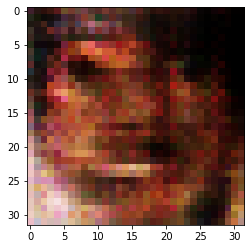

In [96]:
error_d_m2, error_g_m2, prediccion_falsa_m2 = entrenar(gan2, 3000, 150, "resultadosGAN-7/modelo2")

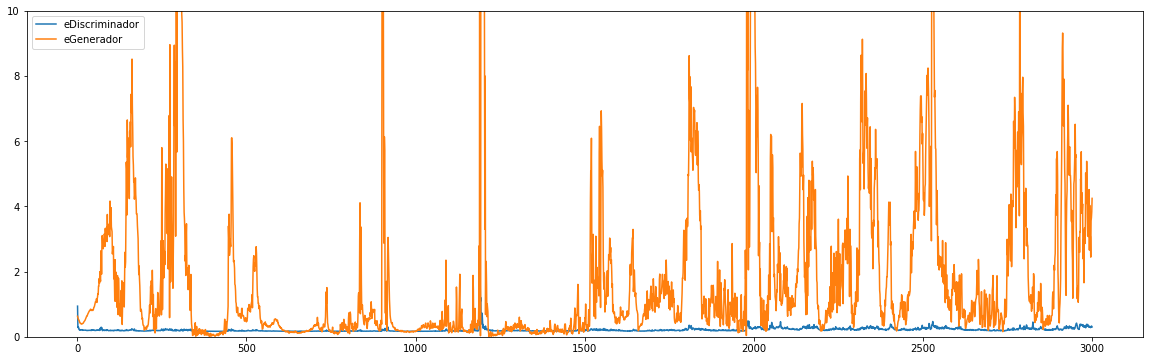

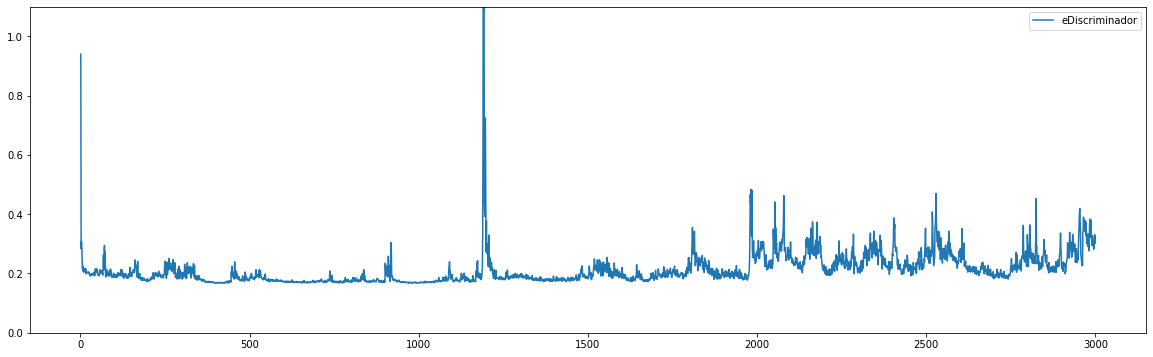

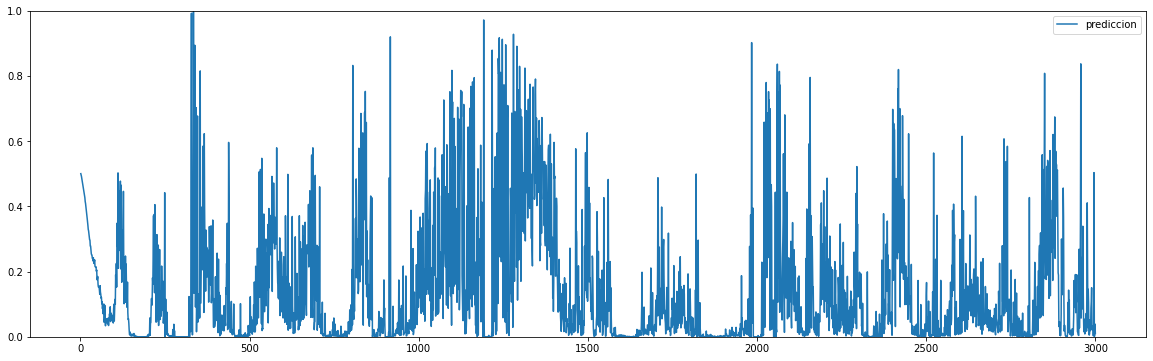

In [97]:
plot_acumulado(len(error_d_m2), 10, eDiscriminador = error_d_m2, eGenerador = error_g_m2)
plot_acumulado(len(error_d_m2), 1.1, eDiscriminador = error_d_m2)
plot_acumulado(len(prediccion_falsa_m2), 1, prediccion = prediccion_falsa_m2)

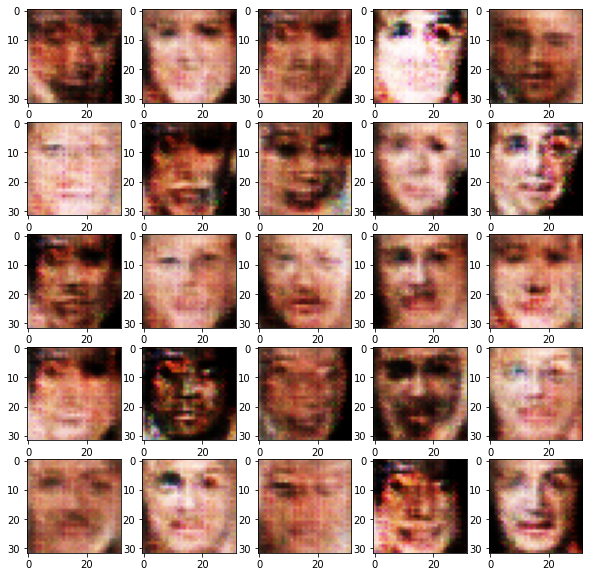

In [130]:
visualizarMosaico(gan2, 5, 5)

Se obtubieron resultados bastante buenos, pero por un error se quedo con el ruido en 0.1

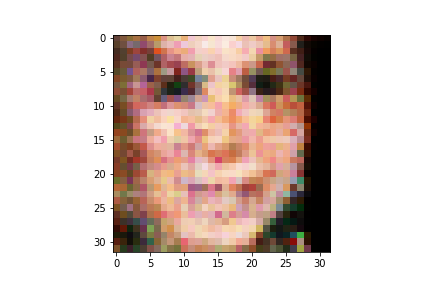

### Tercer modelo

Vamos a corregir el error en el entrenamiento para que elimine el ruido a partir de cierto momento. Vamos a cambiar el dataset

In [11]:
def entrenar(GAN, ITERACIONES, TAM_LOTE, CARPETAGUARDADO, GUARDAR_IMG = 100):
    
    generador = GAN.layers[0]
    discriminador = GAN.layers[1]
    error_d_acumulado = np.array([])
    error_g_acumulado = np.array([])
    prediccion_falsa = np.array([])
    
    for i in range(1, ITERACIONES+1):
        
        LEVEL_NOISE = 0.3
        
        if(i/ITERACIONES > 0.3):
            LEVEL_NOISE = 0.1

        if(i/ITERACIONES > 0.6):
            LEVEL_NOISE = 0
        
        start = time.time()
        print("Comenzando Epoca " + str(i) + ".Ruido:" + str(LEVEL_NOISE), end = "")

        # Crear un "batch" de imágenes falsas y otro con imágenes reales
        ruido = np.random.normal(0, 1, [TAM_LOTE, TAM_ENTRADA])
        batch_falsas = generador.predict(ruido)

        idx = np.random.randint(low=0, high=x_train.shape[0], size= TAM_LOTE)
        batch_reales = x_train[idx]
        
         # Agregamos ruidos a las imagenes segun el LEVEL_NOISE
        if(LEVEL_NOISE == 0):
            batch_reales = batch_reales + LEVEL_NOISE * np.random.normal(loc=0.0, scale=1.0, size=batch_reales.shape)

        # lo ajustamos para que no pase del rango (-1, 1)
            batch_reales = np.clip(batch_reales, -1, 1)

        #la unificacion del batch de entrenamiento es lo que logra que el modelo aprenda
        batch = np.concatenate((batch_reales, batch_falsas))

        #las reales le digo como resultado 1 con np.ones (el 0.9 ayuda a que converga mejor)
        #las falsas le digo como resultado 0 con np.zeros
        valores = np.concatenate((np.ones(TAM_LOTE)*0.9, np.zeros(TAM_LOTE)))

        print(".", end = "")

        discriminador.trainable = True

        # Entrenar discriminador con imagener falsas y reales
        dError = discriminador.train_on_batch(batch, valores)

        error_d_acumulado = np.append(error_d_acumulado, dError)

        #congelo el discriminador
        discriminador.trainable = False

        print(".", end = "")

        # Entrenar GAN: se generará ruido aleatorio y se presentará a la GAN como si fuesen imagenes reales
        ruido = np.random.normal(0, 1, [TAM_LOTE, TAM_ENTRADA])
        gError = GAN.train_on_batch(ruido, np.ones(TAM_LOTE))
            
        error_g_acumulado = np.append(error_g_acumulado, gError)

        print(".", end = "")

        #Cada 100 iteraciones vamos a guardar una imagen
        if i==1 or i%GUARDAR_IMG == 0:
            ruido = np.random.normal(0, 1, TAM_ENTRADA)
            ruido = np.array([ruido])
            resultado = generador.predict(ruido)
            resultado = resultado * 0.5 + 0.5
            plt.imshow(resultado.reshape(TAM_IMG, TAM_IMG, 3))
            plt.savefig(CARPETAGUARDADO + "/r" + str(i) + ".png")

        #hacemos una prueba de prediccion
        ruido = np.random.normal(0, 1, TAM_ENTRADA)
        ruido = np.array([ruido])
        resultado = GAN.predict(ruido)

        prediccion_falsa = np.append(prediccion_falsa, resultado)
        end = time.time()
        print(" Fin")
        print("Tiempo transcurrido: ", round((end - start), 2), "s")
        trm = (ITERACIONES + 1 - i) * (end - start) / 60 #tiempo restante en minutos
        print("Tiempo restante aprox: " + str(round(trm, 2)) + "m -> " + str(int(trm/60)) + ":" + str(int(trm%60)) + "h")
        print("prediccion de ruido: ", resultado)
        print("===================================================================")
     
    return error_d_acumulado, error_g_acumulado, prediccion_falsa

In [12]:
x_train = cargar_datos("dataset2/data_tratada/")

Creando set de entrenamiento...
¡Listo!


In [107]:

OPTIMIZADOR3 = optimizador.Adam(learning_rate=0.0002, beta_1=0.5) 
ERROR3 = 'binary_crossentropy' 

gan3 = crear_GAN(OPTIMIZADOR3, ERROR3)

Creando set de entrenamiento...
¡Listo!

Generador Creado
Discriminador Creado
GAN Creado


Comenzando Epoca 1.Ruido:0.3... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 66.91m -> 1:6h
prediccion de ruido:  [[0.02490288]]
Comenzando Epoca 2.Ruido:0.3... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 62.92m -> 1:2h
prediccion de ruido:  [[0.22492492]]
Comenzando Epoca 3.Ruido:0.3... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 62.45m -> 1:2h
prediccion de ruido:  [[0.26856813]]
Comenzando Epoca 4.Ruido:0.3... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 64.87m -> 1:4h
prediccion de ruido:  [[0.16309714]]
Comenzando Epoca 5.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 63.38m -> 1:3h
prediccion de ruido:  [[0.3071512]]
Comenzando Epoca 6.Ruido:0.3... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 64.18m -> 1:4h
prediccion de ruido:  [[0.14196089]]
Comenzando Epoca 7.Ruido:0.3... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 62.47m -> 1:2h
prediccion de ruido:  [[0.06295842]]
Comenzando Epoca 8.Ruid

Comenzando Epoca 41.Ruido:0.3... Fin
Tiempo transcurrido:  3.02 s
Tiempo restante aprox: 73.51m -> 1:13h
prediccion de ruido:  [[0.01829043]]
Comenzando Epoca 42.Ruido:0.3... Fin
Tiempo transcurrido:  3.16 s
Tiempo restante aprox: 76.88m -> 1:16h
prediccion de ruido:  [[0.04274103]]
Comenzando Epoca 43.Ruido:0.3... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 62.17m -> 1:2h
prediccion de ruido:  [[0.01872408]]
Comenzando Epoca 44.Ruido:0.3... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 63.26m -> 1:3h
prediccion de ruido:  [[0.01714]]
Comenzando Epoca 45.Ruido:0.3... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 63.5m -> 1:3h
prediccion de ruido:  [[0.09296089]]
Comenzando Epoca 46.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 61.66m -> 1:1h
prediccion de ruido:  [[0.0892697]]
Comenzando Epoca 47.Ruido:0.3... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 62.0m -> 1:2h
prediccion de ruido:  [[0.07756594]]
Comenzando Epoca 

Comenzando Epoca 81.Ruido:0.3... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 59.44m -> 0:59h
prediccion de ruido:  [[0.05219194]]
Comenzando Epoca 82.Ruido:0.3... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 59.13m -> 0:59h
prediccion de ruido:  [[1.5593403e-05]]
Comenzando Epoca 83.Ruido:0.3... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 58.99m -> 0:58h
prediccion de ruido:  [[3.667932e-06]]
Comenzando Epoca 84.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 59.9m -> 0:59h
prediccion de ruido:  [[0.01977068]]
Comenzando Epoca 85.Ruido:0.3... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 60.12m -> 1:0h
prediccion de ruido:  [[0.02840462]]
Comenzando Epoca 86.Ruido:0.3... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 60.56m -> 1:0h
prediccion de ruido:  [[0.02778304]]
Comenzando Epoca 87.Ruido:0.3... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 60.29m -> 1:0h
prediccion de ruido:  [[5.776499e-05]]
Comen

Comenzando Epoca 159.Ruido:0.3... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 55.95m -> 0:55h
prediccion de ruido:  [[0.00134546]]
Comenzando Epoca 160.Ruido:0.3... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 56.0m -> 0:56h
prediccion de ruido:  [[0.07134336]]
Comenzando Epoca 161.Ruido:0.3... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 56.13m -> 0:56h
prediccion de ruido:  [[0.00718015]]
Comenzando Epoca 162.Ruido:0.3... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 55.82m -> 0:55h
prediccion de ruido:  [[0.00820431]]
Comenzando Epoca 163.Ruido:0.3... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 56.13m -> 0:56h
prediccion de ruido:  [[0.03742027]]
Comenzando Epoca 164.Ruido:0.3... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 55.79m -> 0:55h
prediccion de ruido:  [[0.06468233]]
Comenzando Epoca 165.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 56.3m -> 0:56h
prediccion de ruido:  [[0.0305711]]
Comen

Comenzando Epoca 198.Ruido:0.3... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 54.38m -> 0:54h
prediccion de ruido:  [[0.01440385]]
Comenzando Epoca 199.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 54.8m -> 0:54h
prediccion de ruido:  [[0.01448295]]
Comenzando Epoca 200.Ruido:0.3... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 56.62m -> 0:56h
prediccion de ruido:  [[0.0042263]]
Comenzando Epoca 201.Ruido:0.3... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 55.6m -> 0:55h
prediccion de ruido:  [[0.00191766]]
Comenzando Epoca 202.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 55.04m -> 0:55h
prediccion de ruido:  [[0.00230074]]
Comenzando Epoca 203.Ruido:0.3... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 55.32m -> 0:55h
prediccion de ruido:  [[0.0034458]]
Comenzando Epoca 204.Ruido:0.3... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 58.5m -> 0:58h
prediccion de ruido:  [[0.00552785]]
Comen

Comenzando Epoca 237.Ruido:0.3... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 52.7m -> 0:52h
prediccion de ruido:  [[0.0304229]]
Comenzando Epoca 238.Ruido:0.3... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 53.02m -> 0:53h
prediccion de ruido:  [[0.11584336]]
Comenzando Epoca 239.Ruido:0.3... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 52.98m -> 0:52h
prediccion de ruido:  [[0.02373296]]
Comenzando Epoca 240.Ruido:0.3... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 52.55m -> 0:52h
prediccion de ruido:  [[0.01350754]]
Comenzando Epoca 241.Ruido:0.3... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 52.83m -> 0:52h
prediccion de ruido:  [[0.01748243]]
Comenzando Epoca 242.Ruido:0.3... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 52.58m -> 0:52h
prediccion de ruido:  [[0.05736944]]
Comenzando Epoca 243.Ruido:0.3... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 52.2m -> 0:52h
prediccion de ruido:  [[0.05672619]]
Come

Comenzando Epoca 276.Ruido:0.3... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 51.28m -> 0:51h
prediccion de ruido:  [[0.05075794]]
Comenzando Epoca 277.Ruido:0.3... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 50.92m -> 0:50h
prediccion de ruido:  [[0.10245112]]
Comenzando Epoca 278.Ruido:0.3... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 51.2m -> 0:51h
prediccion de ruido:  [[0.00111598]]
Comenzando Epoca 279.Ruido:0.3... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 50.84m -> 0:50h
prediccion de ruido:  [[0.60032266]]
Comenzando Epoca 280.Ruido:0.3... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 50.83m -> 0:50h
prediccion de ruido:  [[0.05610001]]
Comenzando Epoca 281.Ruido:0.3... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 51.07m -> 0:51h
prediccion de ruido:  [[0.00889635]]
Comenzando Epoca 282.Ruido:0.3... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 51.03m -> 0:51h
prediccion de ruido:  [[0.05823722]]
Com

Comenzando Epoca 315.Ruido:0.3... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 49.64m -> 0:49h
prediccion de ruido:  [[0.00324041]]
Comenzando Epoca 316.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 49.88m -> 0:49h
prediccion de ruido:  [[2.0407583e-08]]
Comenzando Epoca 317.Ruido:0.3... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 49.01m -> 0:49h
prediccion de ruido:  [[0.00290182]]
Comenzando Epoca 318.Ruido:0.3... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 49.95m -> 0:49h
prediccion de ruido:  [[0.00975558]]
Comenzando Epoca 319.Ruido:0.3... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 49.4m -> 0:49h
prediccion de ruido:  [[0.00287095]]
Comenzando Epoca 320.Ruido:0.3... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 49.41m -> 0:49h
prediccion de ruido:  [[0.0093022]]
Comenzando Epoca 321.Ruido:0.3... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 49.44m -> 0:49h
prediccion de ruido:  [[0.00061631]

Comenzando Epoca 354.Ruido:0.3... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 51.1m -> 0:51h
prediccion de ruido:  [[0.12697995]]
Comenzando Epoca 355.Ruido:0.3... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 48.22m -> 0:48h
prediccion de ruido:  [[0.19971874]]
Comenzando Epoca 356.Ruido:0.3... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 48.13m -> 0:48h
prediccion de ruido:  [[0.2652825]]
Comenzando Epoca 357.Ruido:0.3... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 47.59m -> 0:47h
prediccion de ruido:  [[0.06918126]]
Comenzando Epoca 358.Ruido:0.3... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 47.55m -> 0:47h
prediccion de ruido:  [[0.51966476]]
Comenzando Epoca 359.Ruido:0.3... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 48.84m -> 0:48h
prediccion de ruido:  [[0.38593024]]
Comenzando Epoca 360.Ruido:0.3... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 48.65m -> 0:48h
prediccion de ruido:  [[0.11832365]]
Com

Comenzando Epoca 393.Ruido:0.3... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 46.38m -> 0:46h
prediccion de ruido:  [[0.20399484]]
Comenzando Epoca 394.Ruido:0.3... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 46.09m -> 0:46h
prediccion de ruido:  [[0.12621817]]
Comenzando Epoca 395.Ruido:0.3... Fin
Tiempo transcurrido:  2.49 s
Tiempo restante aprox: 45.94m -> 0:45h
prediccion de ruido:  [[0.14406759]]
Comenzando Epoca 396.Ruido:0.3... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 46.02m -> 0:46h
prediccion de ruido:  [[0.3469111]]
Comenzando Epoca 397.Ruido:0.3... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 46.29m -> 0:46h
prediccion de ruido:  [[0.16263977]]
Comenzando Epoca 398.Ruido:0.3... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 46.66m -> 0:46h
prediccion de ruido:  [[0.18336749]]
Comenzando Epoca 399.Ruido:0.3... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 50.49m -> 0:50h
prediccion de ruido:  [[0.20646334]]
Co

Comenzando Epoca 432.Ruido:0.3... Fin
Tiempo transcurrido:  2.5 s
Tiempo restante aprox: 44.5m -> 0:44h
prediccion de ruido:  [[0.49892932]]
Comenzando Epoca 433.Ruido:0.3... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 46.1m -> 0:46h
prediccion de ruido:  [[0.27289814]]
Comenzando Epoca 434.Ruido:0.3... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 46.88m -> 0:46h
prediccion de ruido:  [[0.57447994]]
Comenzando Epoca 435.Ruido:0.3... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 47.46m -> 0:47h
prediccion de ruido:  [[0.34980878]]
Comenzando Epoca 436.Ruido:0.3... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 48.88m -> 0:48h
prediccion de ruido:  [[0.14967963]]
Comenzando Epoca 437.Ruido:0.3... Fin
Tiempo transcurrido:  2.96 s
Tiempo restante aprox: 52.46m -> 0:52h
prediccion de ruido:  [[0.21505702]]
Comenzando Epoca 438.Ruido:0.3... Fin
Tiempo transcurrido:  3.66 s
Tiempo restante aprox: 64.82m -> 1:4h
prediccion de ruido:  [[0.8074228]]
Come

Comenzando Epoca 471.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 43.44m -> 0:43h
prediccion de ruido:  [[0.14815426]]
Comenzando Epoca 472.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 43.34m -> 0:43h
prediccion de ruido:  [[0.13690794]]
Comenzando Epoca 473.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 43.03m -> 0:43h
prediccion de ruido:  [[0.00802964]]
Comenzando Epoca 474.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 43.26m -> 0:43h
prediccion de ruido:  [[0.5415018]]
Comenzando Epoca 475.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 42.97m -> 0:42h
prediccion de ruido:  [[0.0075247]]
Comenzando Epoca 476.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 42.94m -> 0:42h
prediccion de ruido:  [[0.03844324]]
Comenzando Epoca 477.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 43.13m -> 0:43h
prediccion de ruido:  [[0.44148725]]
C

Comenzando Epoca 510.Ruido:0.1... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 44.78m -> 0:44h
prediccion de ruido:  [[0.03724805]]
Comenzando Epoca 511.Ruido:0.1... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 43.23m -> 0:43h
prediccion de ruido:  [[0.01226422]]
Comenzando Epoca 512.Ruido:0.1... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 44.45m -> 0:44h
prediccion de ruido:  [[0.05067566]]
Comenzando Epoca 513.Ruido:0.1... Fin
Tiempo transcurrido:  3.08 s
Tiempo restante aprox: 50.69m -> 0:50h
prediccion de ruido:  [[0.18069208]]
Comenzando Epoca 514.Ruido:0.1... Fin
Tiempo transcurrido:  2.91 s
Tiempo restante aprox: 47.81m -> 0:47h
prediccion de ruido:  [[0.05987081]]
Comenzando Epoca 515.Ruido:0.1... Fin
Tiempo transcurrido:  2.91 s
Tiempo restante aprox: 47.89m -> 0:47h
prediccion de ruido:  [[0.01264164]]
Comenzando Epoca 516.Ruido:0.1... Fin
Tiempo transcurrido:  2.82 s
Tiempo restante aprox: 46.31m -> 0:46h
prediccion de ruido:  [[0.07431054]]


Comenzando Epoca 549.Ruido:0.1... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 41.84m -> 0:41h
prediccion de ruido:  [[0.01035592]]
Comenzando Epoca 550.Ruido:0.1... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 41.78m -> 0:41h
prediccion de ruido:  [[0.01341572]]
Comenzando Epoca 551.Ruido:0.1... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 40.71m -> 0:40h
prediccion de ruido:  [[0.016532]]
Comenzando Epoca 552.Ruido:0.1... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 41.03m -> 0:41h
prediccion de ruido:  [[0.00908431]]
Comenzando Epoca 553.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 39.91m -> 0:39h
prediccion de ruido:  [[0.05835855]]
Comenzando Epoca 554.Ruido:0.1... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 41.61m -> 0:41h
prediccion de ruido:  [[0.01799417]]
Comenzando Epoca 555.Ruido:0.1... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 40.26m -> 0:40h
prediccion de ruido:  [[0.29261452]]
C

Comenzando Epoca 588.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 38.25m -> 0:38h
prediccion de ruido:  [[0.02291939]]
Comenzando Epoca 589.Ruido:0.1... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 38.76m -> 0:38h
prediccion de ruido:  [[0.00351989]]
Comenzando Epoca 590.Ruido:0.1... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 38.97m -> 0:38h
prediccion de ruido:  [[0.00146285]]
Comenzando Epoca 591.Ruido:0.1... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 38.89m -> 0:38h
prediccion de ruido:  [[0.00153267]]
Comenzando Epoca 592.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 38.52m -> 0:38h
prediccion de ruido:  [[0.0039514]]
Comenzando Epoca 593.Ruido:0.1... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 38.01m -> 0:38h
prediccion de ruido:  [[0.0109342]]
Comenzando Epoca 594.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 38.2m -> 0:38h
prediccion de ruido:  [[0.0058772]]
Com

Comenzando Epoca 627.Ruido:0.1... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 37.91m -> 0:37h
prediccion de ruido:  [[0.07013008]]
Comenzando Epoca 628.Ruido:0.1... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 36.66m -> 0:36h
prediccion de ruido:  [[0.02635437]]
Comenzando Epoca 629.Ruido:0.1... Fin
Tiempo transcurrido:  2.52 s
Tiempo restante aprox: 36.65m -> 0:36h
prediccion de ruido:  [[0.06783861]]
Comenzando Epoca 630.Ruido:0.1... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 37.26m -> 0:37h
prediccion de ruido:  [[0.01342246]]
Comenzando Epoca 631.Ruido:0.1... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 36.96m -> 0:36h
prediccion de ruido:  [[0.0457533]]
Comenzando Epoca 632.Ruido:0.1... Fin
Tiempo transcurrido:  2.83 s
Tiempo restante aprox: 41.03m -> 0:41h
prediccion de ruido:  [[0.02629203]]
Comenzando Epoca 633.Ruido:0.1... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 38.44m -> 0:38h
prediccion de ruido:  [[0.0045853]]
Co

Comenzando Epoca 666.Ruido:0.1... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 36.09m -> 0:36h
prediccion de ruido:  [[0.04054123]]
Comenzando Epoca 667.Ruido:0.1... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 35.47m -> 0:35h
prediccion de ruido:  [[0.00452301]]
Comenzando Epoca 668.Ruido:0.1... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 35.36m -> 0:35h
prediccion de ruido:  [[0.06190944]]
Comenzando Epoca 669.Ruido:0.1... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 35.91m -> 0:35h
prediccion de ruido:  [[0.00477552]]
Comenzando Epoca 670.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 35.23m -> 0:35h
prediccion de ruido:  [[0.00307822]]
Comenzando Epoca 671.Ruido:0.1... Fin
Tiempo transcurrido:  2.78 s
Tiempo restante aprox: 38.52m -> 0:38h
prediccion de ruido:  [[0.00064725]]
Comenzando Epoca 672.Ruido:0.1... Fin
Tiempo transcurrido:  2.72 s
Tiempo restante aprox: 37.52m -> 0:37h
prediccion de ruido:  [[0.01448143]]

Comenzando Epoca 705.Ruido:0.1... Fin
Tiempo transcurrido:  2.68 s
Tiempo restante aprox: 35.5m -> 0:35h
prediccion de ruido:  [[0.0323897]]
Comenzando Epoca 706.Ruido:0.1... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 34.0m -> 0:34h
prediccion de ruido:  [[0.58510345]]
Comenzando Epoca 707.Ruido:0.1... Fin
Tiempo transcurrido:  2.48 s
Tiempo restante aprox: 32.88m -> 0:32h
prediccion de ruido:  [[0.3337499]]
Comenzando Epoca 708.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 33.59m -> 0:33h
prediccion de ruido:  [[0.01364398]]
Comenzando Epoca 709.Ruido:0.1... Fin
Tiempo transcurrido:  2.92 s
Tiempo restante aprox: 38.56m -> 0:38h
prediccion de ruido:  [[0.01432294]]
Comenzando Epoca 710.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 33.37m -> 0:33h
prediccion de ruido:  [[0.0863024]]
Comenzando Epoca 711.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 33.34m -> 0:33h
prediccion de ruido:  [[0.03434139]]
Come

Comenzando Epoca 744.Ruido:0.1... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 34.09m -> 0:34h
prediccion de ruido:  [[0.2050069]]
Comenzando Epoca 745.Ruido:0.1... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 33.61m -> 0:33h
prediccion de ruido:  [[0.6746472]]
Comenzando Epoca 746.Ruido:0.1... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 32.92m -> 0:32h
prediccion de ruido:  [[0.20083082]]
Comenzando Epoca 747.Ruido:0.1... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 33.29m -> 0:33h
prediccion de ruido:  [[0.03634065]]
Comenzando Epoca 748.Ruido:0.1... Fin
Tiempo transcurrido:  2.74 s
Tiempo restante aprox: 34.39m -> 0:34h
prediccion de ruido:  [[0.27175304]]
Comenzando Epoca 749.Ruido:0.1... Fin
Tiempo transcurrido:  2.77 s
Tiempo restante aprox: 34.68m -> 0:34h
prediccion de ruido:  [[0.56088793]]
Comenzando Epoca 750.Ruido:0.1... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 32.53m -> 0:32h
prediccion de ruido:  [[0.48852122]]
Com

Comenzando Epoca 783.Ruido:0.1... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 31.88m -> 0:31h
prediccion de ruido:  [[0.47670633]]
Comenzando Epoca 784.Ruido:0.1... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 31.51m -> 0:31h
prediccion de ruido:  [[0.68134224]]
Comenzando Epoca 785.Ruido:0.1... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 31.37m -> 0:31h
prediccion de ruido:  [[0.7584976]]
Comenzando Epoca 786.Ruido:0.1... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 30.65m -> 0:30h
prediccion de ruido:  [[0.74025583]]
Comenzando Epoca 787.Ruido:0.1... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 30.16m -> 0:30h
prediccion de ruido:  [[0.46260372]]
Comenzando Epoca 788.Ruido:0.1... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 31.64m -> 0:31h
prediccion de ruido:  [[0.5081465]]
Comenzando Epoca 789.Ruido:0.1... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 32.1m -> 0:32h
prediccion de ruido:  [[0.36120206]]
Co

Comenzando Epoca 822.Ruido:0.1... Fin
Tiempo transcurrido:  2.67 s
Tiempo restante aprox: 30.21m -> 0:30h
prediccion de ruido:  [[0.42374796]]
Comenzando Epoca 823.Ruido:0.1... Fin
Tiempo transcurrido:  2.86 s
Tiempo restante aprox: 32.35m -> 0:32h
prediccion de ruido:  [[0.66042054]]
Comenzando Epoca 824.Ruido:0.1... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 29.5m -> 0:29h
prediccion de ruido:  [[0.29411793]]
Comenzando Epoca 825.Ruido:0.1... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 29.65m -> 0:29h
prediccion de ruido:  [[0.761032]]
Comenzando Epoca 826.Ruido:0.1... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 30.37m -> 0:30h
prediccion de ruido:  [[0.6470254]]
Comenzando Epoca 827.Ruido:0.1... Fin
Tiempo transcurrido:  2.75 s
Tiempo restante aprox: 30.89m -> 0:30h
prediccion de ruido:  [[0.5537751]]
Comenzando Epoca 828.Ruido:0.1... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 28.54m -> 0:28h
prediccion de ruido:  [[0.02209425]]
Comen

Comenzando Epoca 861.Ruido:0.1... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 27.83m -> 0:27h
prediccion de ruido:  [[0.49249452]]
Comenzando Epoca 862.Ruido:0.1... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 27.52m -> 0:27h
prediccion de ruido:  [[0.5580878]]
Comenzando Epoca 863.Ruido:0.1... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 27.48m -> 0:27h
prediccion de ruido:  [[0.3527456]]
Comenzando Epoca 864.Ruido:0.1... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 28.68m -> 0:28h
prediccion de ruido:  [[0.4019488]]
Comenzando Epoca 865.Ruido:0.1... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 28.16m -> 0:28h
prediccion de ruido:  [[0.15287083]]
Comenzando Epoca 866.Ruido:0.1... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 28.14m -> 0:28h
prediccion de ruido:  [[0.6645422]]
Comenzando Epoca 867.Ruido:0.1... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 28.47m -> 0:28h
prediccion de ruido:  [[0.66041934]]
Come

Comenzando Epoca 900.Ruido:0.1... Fin
Tiempo transcurrido:  2.76 s
Tiempo restante aprox: 27.66m -> 0:27h
prediccion de ruido:  [[0.69389594]]
Comenzando Epoca 901.Ruido:0... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 26.43m -> 0:26h
prediccion de ruido:  [[0.43642384]]
Comenzando Epoca 902.Ruido:0... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 25.38m -> 0:25h
prediccion de ruido:  [[0.33026433]]
Comenzando Epoca 903.Ruido:0... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 26.33m -> 0:26h
prediccion de ruido:  [[0.18052256]]
Comenzando Epoca 904.Ruido:0... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 25.8m -> 0:25h
prediccion de ruido:  [[0.17869145]]
Comenzando Epoca 905.Ruido:0... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 26.24m -> 0:26h
prediccion de ruido:  [[0.5619862]]
Comenzando Epoca 906.Ruido:0... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 25.7m -> 0:25h
prediccion de ruido:  [[0.03790241]]
Comenzando Epo

Comenzando Epoca 940.Ruido:0... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 24.51m -> 0:24h
prediccion de ruido:  [[0.6772902]]
Comenzando Epoca 941.Ruido:0... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 24.16m -> 0:24h
prediccion de ruido:  [[0.13235378]]
Comenzando Epoca 942.Ruido:0... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 24.29m -> 0:24h
prediccion de ruido:  [[0.0465886]]
Comenzando Epoca 943.Ruido:0... Fin
Tiempo transcurrido:  2.65 s
Tiempo restante aprox: 24.65m -> 0:24h
prediccion de ruido:  [[0.13842866]]
Comenzando Epoca 944.Ruido:0... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 24.09m -> 0:24h
prediccion de ruido:  [[0.31674522]]
Comenzando Epoca 945.Ruido:0... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 23.6m -> 0:23h
prediccion de ruido:  [[0.3300522]]
Comenzando Epoca 946.Ruido:0... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 23.56m -> 0:23h
prediccion de ruido:  [[0.17128879]]
Comenzando Epoca 9

Comenzando Epoca 980.Ruido:0... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 22.49m -> 0:22h
prediccion de ruido:  [[0.01228416]]
Comenzando Epoca 981.Ruido:0... Fin
Tiempo transcurrido:  2.79 s
Tiempo restante aprox: 24.15m -> 0:24h
prediccion de ruido:  [[0.0013583]]
Comenzando Epoca 982.Ruido:0... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 22.48m -> 0:22h
prediccion de ruido:  [[0.00234473]]
Comenzando Epoca 983.Ruido:0... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 22.15m -> 0:22h
prediccion de ruido:  [[0.0049797]]
Comenzando Epoca 984.Ruido:0... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 23.17m -> 0:23h
prediccion de ruido:  [[0.00951794]]
Comenzando Epoca 985.Ruido:0... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 22.25m -> 0:22h
prediccion de ruido:  [[0.11421928]]
Comenzando Epoca 986.Ruido:0... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 23.28m -> 0:23h
prediccion de ruido:  [[0.07153183]]
Comenzando Epoca

Comenzando Epoca 1020.Ruido:0... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 20.55m -> 0:20h
prediccion de ruido:  [[0.00449455]]
Comenzando Epoca 1021.Ruido:0... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 20.36m -> 0:20h
prediccion de ruido:  [[0.04211015]]
Comenzando Epoca 1022.Ruido:0... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 21.2m -> 0:21h
prediccion de ruido:  [[0.03635177]]
Comenzando Epoca 1023.Ruido:0... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 20.47m -> 0:20h
prediccion de ruido:  [[0.02427891]]
Comenzando Epoca 1024.Ruido:0... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 20.91m -> 0:20h
prediccion de ruido:  [[0.00417763]]
Comenzando Epoca 1025.Ruido:0... Fin
Tiempo transcurrido:  2.76 s
Tiempo restante aprox: 21.91m -> 0:21h
prediccion de ruido:  [[0.03022772]]
Comenzando Epoca 1026.Ruido:0... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 20.59m -> 0:20h
prediccion de ruido:  [[0.0299741]]
Comenzand

Comenzando Epoca 1098.Ruido:0... Fin
Tiempo transcurrido:  2.64 s
Tiempo restante aprox: 17.74m -> 0:17h
prediccion de ruido:  [[8.434611e-05]]
Comenzando Epoca 1099.Ruido:0... Fin
Tiempo transcurrido:  2.59 s
Tiempo restante aprox: 17.37m -> 0:17h
prediccion de ruido:  [[0.01223701]]
Comenzando Epoca 1100.Ruido:0... Fin
Tiempo transcurrido:  2.71 s
Tiempo restante aprox: 18.1m -> 0:18h
prediccion de ruido:  [[0.00132242]]
Comenzando Epoca 1101.Ruido:0... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 17.92m -> 0:17h
prediccion de ruido:  [[0.0048759]]
Comenzando Epoca 1102.Ruido:0... Fin
Tiempo transcurrido:  2.69 s
Tiempo restante aprox: 17.91m -> 0:17h
prediccion de ruido:  [[0.00258064]]
Comenzando Epoca 1103.Ruido:0... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 17.13m -> 0:17h
prediccion de ruido:  [[0.00562084]]
Comenzando Epoca 1104.Ruido:0... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 17.04m -> 0:17h
prediccion de ruido:  [[0.006825]]
Comenzan

Comenzando Epoca 1176.Ruido:0... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 13.75m -> 0:13h
prediccion de ruido:  [[0.00074509]]
Comenzando Epoca 1177.Ruido:0... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 13.7m -> 0:13h
prediccion de ruido:  [[0.00079539]]
Comenzando Epoca 1178.Ruido:0... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 13.85m -> 0:13h
prediccion de ruido:  [[6.4633845e-05]]
Comenzando Epoca 1179.Ruido:0... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 13.87m -> 0:13h
prediccion de ruido:  [[0.00104088]]
Comenzando Epoca 1180.Ruido:0... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 13.77m -> 0:13h
prediccion de ruido:  [[0.00417712]]
Comenzando Epoca 1181.Ruido:0... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 13.77m -> 0:13h
prediccion de ruido:  [[0.0014737]]
Comenzando Epoca 1182.Ruido:0... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 13.56m -> 0:13h
prediccion de ruido:  [[0.00148693]]
Comen

Comenzando Epoca 1215.Ruido:0... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 12.12m -> 0:12h
prediccion de ruido:  [[0.06990144]]
Comenzando Epoca 1216.Ruido:0... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 12.0m -> 0:12h
prediccion de ruido:  [[0.05782834]]
Comenzando Epoca 1217.Ruido:0... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 11.96m -> 0:11h
prediccion de ruido:  [[0.01859796]]
Comenzando Epoca 1218.Ruido:0... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 11.99m -> 0:11h
prediccion de ruido:  [[0.01380739]]
Comenzando Epoca 1219.Ruido:0... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 11.95m -> 0:11h
prediccion de ruido:  [[0.00033891]]
Comenzando Epoca 1220.Ruido:0... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 11.91m -> 0:11h
prediccion de ruido:  [[0.00574291]]
Comenzando Epoca 1221.Ruido:0... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 11.87m -> 0:11h
prediccion de ruido:  [[0.02067423]]
Comenza

Comenzando Epoca 1294.Ruido:0... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 8.8m -> 0:8h
prediccion de ruido:  [[0.13177127]]
Comenzando Epoca 1295.Ruido:0... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 9.14m -> 0:9h
prediccion de ruido:  [[0.4603725]]
Comenzando Epoca 1296.Ruido:0... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 8.87m -> 0:8h
prediccion de ruido:  [[0.29867435]]
Comenzando Epoca 1297.Ruido:0... Fin
Tiempo transcurrido:  2.86 s
Tiempo restante aprox: 9.73m -> 0:9h
prediccion de ruido:  [[0.3502184]]
Comenzando Epoca 1298.Ruido:0... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 8.91m -> 0:8h
prediccion de ruido:  [[0.6105244]]
Comenzando Epoca 1299.Ruido:0... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 8.8m -> 0:8h
prediccion de ruido:  [[0.53549093]]
Comenzando Epoca 1300.Ruido:0... Fin
Tiempo transcurrido:  2.83 s
Tiempo restante aprox: 9.48m -> 0:9h
prediccion de ruido:  [[0.10018507]]
Comenzando Epoca 1301.Ruid

Comenzando Epoca 1334.Ruido:0... Fin
Tiempo transcurrido:  2.62 s
Tiempo restante aprox: 7.28m -> 0:7h
prediccion de ruido:  [[0.11878225]]
Comenzando Epoca 1335.Ruido:0... Fin
Tiempo transcurrido:  2.66 s
Tiempo restante aprox: 7.35m -> 0:7h
prediccion de ruido:  [[0.43254566]]
Comenzando Epoca 1336.Ruido:0... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 6.99m -> 0:6h
prediccion de ruido:  [[0.4378413]]
Comenzando Epoca 1337.Ruido:0... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 7.04m -> 0:7h
prediccion de ruido:  [[0.17237207]]
Comenzando Epoca 1338.Ruido:0... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 7.13m -> 0:7h
prediccion de ruido:  [[0.41744074]]
Comenzando Epoca 1339.Ruido:0... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 6.92m -> 0:6h
prediccion de ruido:  [[0.03169703]]
Comenzando Epoca 1340.Ruido:0... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 6.87m -> 0:6h
prediccion de ruido:  [[0.3443239]]
Comenzando Epoca 1341.

Comenzando Epoca 1374.Ruido:0... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 5.43m -> 0:5h
prediccion de ruido:  [[0.00085148]]
Comenzando Epoca 1375.Ruido:0... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 5.33m -> 0:5h
prediccion de ruido:  [[0.01167819]]
Comenzando Epoca 1376.Ruido:0... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 5.27m -> 0:5h
prediccion de ruido:  [[0.00074637]]
Comenzando Epoca 1377.Ruido:0... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 5.23m -> 0:5h
prediccion de ruido:  [[2.0329805e-06]]
Comenzando Epoca 1378.Ruido:0... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 5.22m -> 0:5h
prediccion de ruido:  [[0.00029278]]
Comenzando Epoca 1379.Ruido:0... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 5.19m -> 0:5h
prediccion de ruido:  [[0.00039002]]
Comenzando Epoca 1380.Ruido:0... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 5.11m -> 0:5h
prediccion de ruido:  [[4.3207492e-05]]
Comenzando Epo

Comenzando Epoca 1414.Ruido:0... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 3.78m -> 0:3h
prediccion de ruido:  [[0.05463463]]
Comenzando Epoca 1415.Ruido:0... Fin
Tiempo transcurrido:  2.61 s
Tiempo restante aprox: 3.75m -> 0:3h
prediccion de ruido:  [[0.08368742]]
Comenzando Epoca 1416.Ruido:0... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 3.73m -> 0:3h
prediccion de ruido:  [[0.03233254]]
Comenzando Epoca 1417.Ruido:0... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 3.54m -> 0:3h
prediccion de ruido:  [[0.03370011]]
Comenzando Epoca 1418.Ruido:0... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 3.47m -> 0:3h
prediccion de ruido:  [[0.00221941]]
Comenzando Epoca 1419.Ruido:0... Fin
Tiempo transcurrido:  2.51 s
Tiempo restante aprox: 3.43m -> 0:3h
prediccion de ruido:  [[0.00413695]]
Comenzando Epoca 1420.Ruido:0... Fin
Tiempo transcurrido:  2.63 s
Tiempo restante aprox: 3.56m -> 0:3h
prediccion de ruido:  [[0.00455037]]
Comenzando Epoca 142

Comenzando Epoca 1454.Ruido:0... Fin
Tiempo transcurrido:  2.57 s
Tiempo restante aprox: 2.01m -> 0:2h
prediccion de ruido:  [[0.80967546]]
Comenzando Epoca 1455.Ruido:0... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 1.96m -> 0:1h
prediccion de ruido:  [[0.3893484]]
Comenzando Epoca 1456.Ruido:0... Fin
Tiempo transcurrido:  2.54 s
Tiempo restante aprox: 1.9m -> 0:1h
prediccion de ruido:  [[0.40512225]]
Comenzando Epoca 1457.Ruido:0... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 1.85m -> 0:1h
prediccion de ruido:  [[0.20435074]]
Comenzando Epoca 1458.Ruido:0... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 1.86m -> 0:1h
prediccion de ruido:  [[0.18491569]]
Comenzando Epoca 1459.Ruido:0... Fin
Tiempo transcurrido:  2.6 s
Tiempo restante aprox: 1.82m -> 0:1h
prediccion de ruido:  [[0.10810012]]
Comenzando Epoca 1460.Ruido:0... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 1.73m -> 0:1h
prediccion de ruido:  [[0.23923144]]
Comenzando Epoca 1461.Ru

Comenzando Epoca 1494.Ruido:0... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 0.29m -> 0:0h
prediccion de ruido:  [[0.01056007]]
Comenzando Epoca 1495.Ruido:0... Fin
Tiempo transcurrido:  2.55 s
Tiempo restante aprox: 0.26m -> 0:0h
prediccion de ruido:  [[0.09101656]]
Comenzando Epoca 1496.Ruido:0... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 0.21m -> 0:0h
prediccion de ruido:  [[0.05574378]]
Comenzando Epoca 1497.Ruido:0... Fin
Tiempo transcurrido:  2.56 s
Tiempo restante aprox: 0.17m -> 0:0h
prediccion de ruido:  [[0.08986312]]
Comenzando Epoca 1498.Ruido:0... Fin
Tiempo transcurrido:  2.58 s
Tiempo restante aprox: 0.13m -> 0:0h
prediccion de ruido:  [[0.16096458]]
Comenzando Epoca 1499.Ruido:0... Fin
Tiempo transcurrido:  2.53 s
Tiempo restante aprox: 0.08m -> 0:0h
prediccion de ruido:  [[0.08376431]]
Comenzando Epoca 1500.Ruido:0... Fin
Tiempo transcurrido:  2.7 s
Tiempo restante aprox: 0.04m -> 0:0h
prediccion de ruido:  [[0.10314825]]


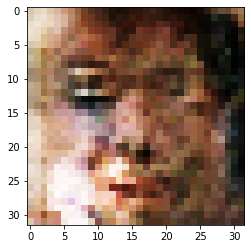

In [113]:
error_d_m3, error_g_m3, prediccion_falsa_m3 = entrenar(gan3, 1500, 150, "resultadosGAN-7/modelo3")

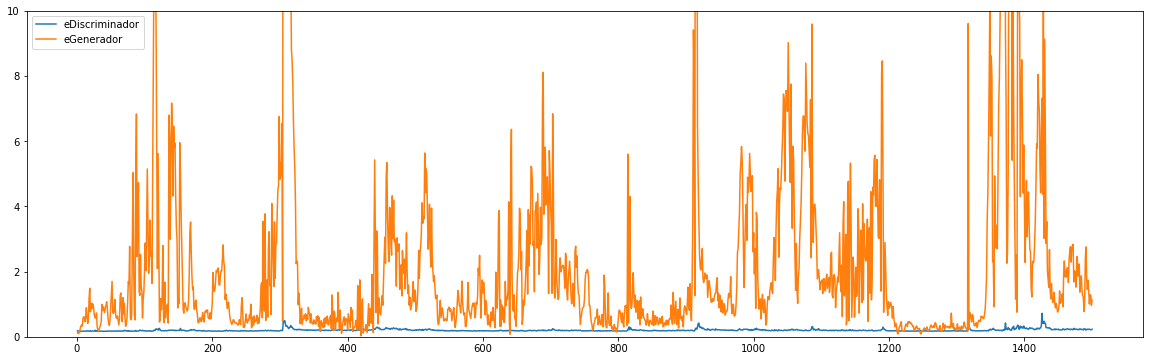

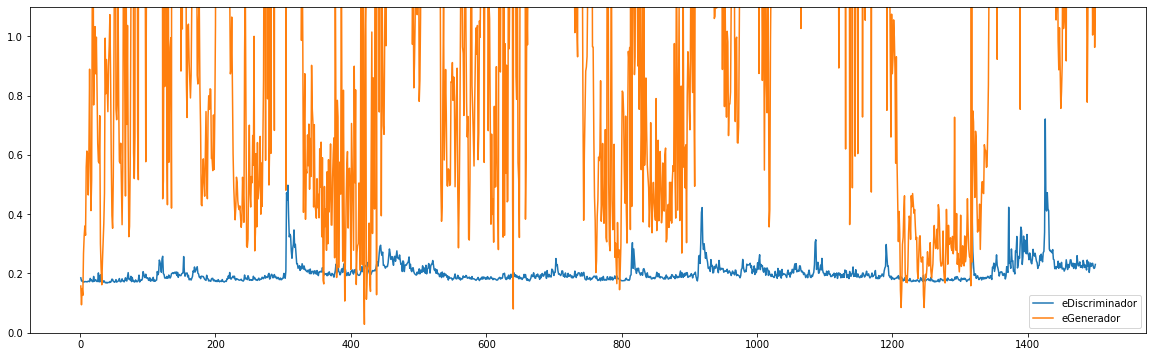

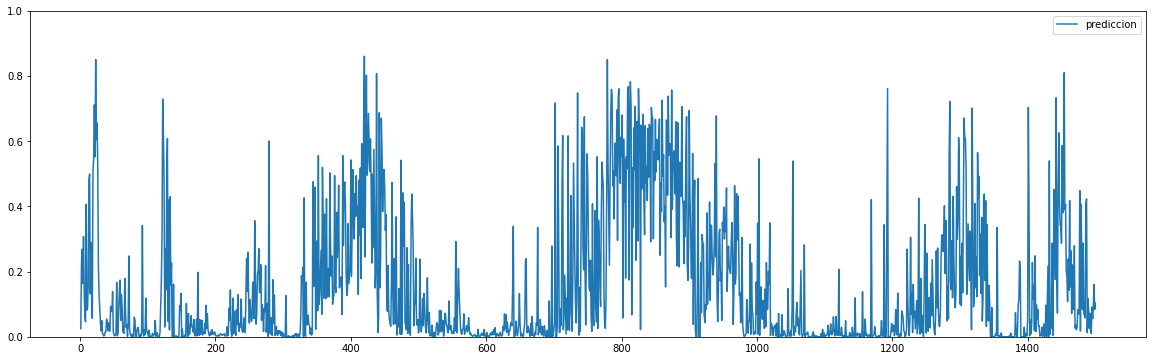

In [114]:
plot_acumulado(len(error_d_m3), 10, eDiscriminador = error_d_m3, eGenerador = error_g_m3)
plot_acumulado(len(error_d_m3), 1.1, eDiscriminador = error_d_m3, eGenerador = error_g_m3)
plot_acumulado(len(prediccion_falsa_m3), 1, prediccion = prediccion_falsa_m3)

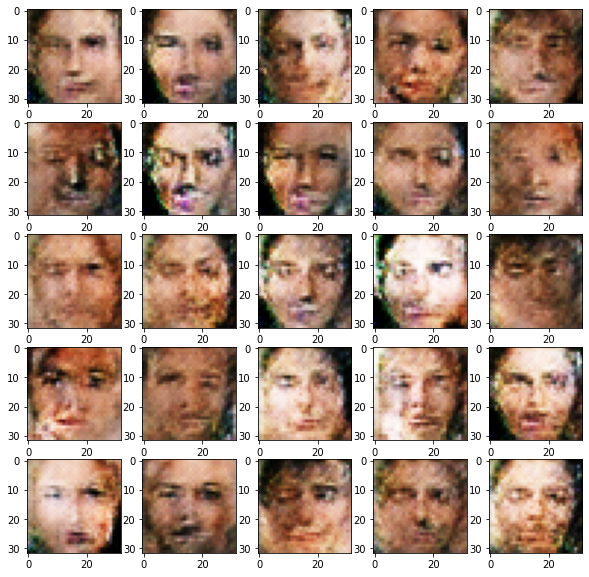

In [133]:
visualizarMosaico(gan3, 5, 5)

In [134]:
gan3.save("resultadosGAN-7/modelo3/gan.h5")